In [27]:
import os
import json
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image ,ImageOps
from collections import defaultdict
import glob
import shutil
from pathlib import Path
import torch
from ultralytics import YOLO
import pandas as pd
%matplotlib inline


# Step 1: Setup Environment & Install Dependencies

In this step, we will:
- Install the required libraries (Ultralytics YOLOv8, PyTorch, etc.)
- Verify that GPU is available (important for training speed)
- Import the dependencies we will use later

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("✅ Torch version:", torch.__version__)
print("✅ Using device:", device)



✅ Torch version: 2.7.1+cpu
✅ Using device: cpu


In [6]:
import cv2
resized_img=[]
def show_resized_image(image, max_width=1000, max_height=800):
    global scale
    h, w = image.shape[:2]
    scale = min(max_width / w, max_height / h, 1.0)
    resized_image = cv2.resize(image, (int(w * scale), int(h * scale)))
    return resized_image

# Define dataset path
DATASET_DIR = "final_dataset\\Drive"
CLASSES = ["ALL", "AML", "CLL","CML"]
# for cls in CLASSES:
#     img_path = os.path.join(DATASET_DIR,cls)
#     image_files = [f for f in os.listdir(img_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

#     for img_file in image_files:
#         image_path = os.path.join(img_path, img_file)
#         image = cv2.imread(image_path)
#         resized_img = show_resized_image(image)


# Step 2: Organize Dataset

In this step, we prepare the dataset in the correct structure for YOLOv8 training.

Our dataset is organized as follows:

final_dataset/
ALL/
images/
img_1.png
img_2.png
...
annotations/
img_1.json
img_2.json
...
AML/
images/
annotations/
CLL/
images/
annotations/
CML/
images/
annotations/

- Each subtype of leukemia (ALL, AML, CLL, CML) has its **own folder**.
- Each folder contains:
  - `images/` → patient smear images
  - `annotations/` → COCO-style JSON annotation files (bounding boxes + labels)

Next, we will display some random samples to confirm the dataset integrity.

In [7]:
# Step 2: Dataset Visualization (Show Example Images with Bounding Boxes)


def load_annotation(json_path):
    """Load bounding box annotations from JSON file."""
    with open(json_path, "r") as f:
        data = json.load(f)
    return data.get("box", [])

def show_random_examples(num_examples=3):
    """Show random dataset samples with bounding boxes."""
    fig, axes = plt.subplots(num_examples, 1, figsize=(60, 50))
    
    for ax in axes:
        # Pick a random class folder
        cls = random.choice(CLASSES)
        img_dir = os.path.join(DATASET_DIR, cls)
        ann_dir = os.path.join(img_dir, "annotations")
        
        # Pick a random image (skip non-images)
        img_files = [f for f in os.listdir(img_dir) if f.lower().endswith(('.jpg', '.png', '.jpeg'))]
        img_file = random.choice(img_files)
        img_path = os.path.join(img_dir, img_file)
        # print(img_path)
        
        # Match annotation (same filename but .json)
        json_file = os.path.splitext(img_file)[0] + ".json"
        json_path = os.path.join(ann_dir, json_file)
        # print(json_path)
        # Open image
        img = Image.open(img_path).convert("RGB")
        img = ImageOps.exif_transpose(img)  # auto-rotate according to EXIF
        ax.imshow(img)
        # ax.set_xlim([0, img.width])   # lock x axis to image size
        # ax.set_ylim([img.height, 0])  # lock y axis (invert to match image coords)
        ax.axis("off")
        ax.set_title(f"{cls} - {img_file}", fontsize=10)
        
        # Draw bounding boxes if annotation exists
        if os.path.exists(json_path):
            boxes = load_annotation(json_path)

            # Lock axes to image dimensions
            ax.set_xlim([0, img.width])
            ax.set_ylim([img.height, 0])  # important: invert y axis!

            for b in boxes:
                x, y, w, h = b["x"], b["y"], b["width"], b["height"]

                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2, edgecolor="red", facecolor="none"
                )
                ax.add_patch(rect)
                ax.text(x, y - 5, cls, color="yellow", fontsize=8, weight="bold",
                        bbox=dict(facecolor="black", alpha=0.5, edgecolor="none"))

    plt.tight_layout()
    plt.show()

# Run visualization
show_random_examples(num_examples=10)


<Figure size 6000x5000 with 10 Axes>

# Print the dataset statistics summary 
**(number of images, total bounding boxes, average boxes per image, min/max sizes, etc.).**

In [8]:


# Path to your dataset
dataset_path = "final_dataset\\Drive"

# Classes (same as your folder names)
classes = ["ALL", "AML", "CLL","CML"]

# Stats containers
stats = defaultdict(lambda: {"images": 0, "bboxes": 0, "widths": [], "heights": []})

# Loop through classes
for cls in classes:
    img_dir = os.path.join(dataset_path, cls)
    ann_dir = os.path.join(dataset_path, cls, "annotations")

    # Count images
    stats[cls]["images"] = len(os.listdir(img_dir))-1

    # Parse annotations
    for ann_file in os.listdir(ann_dir):
        if ann_file.endswith(".json"):
            with open(os.path.join(ann_dir, ann_file), "r") as f:
                data = json.load(f)

            # Example: COCO-like JSON with "annotations"
            for ann in data.get("box", []):
                stats[cls]["bboxes"] += 1
                x, y, w, h = ann["x"],ann["y"],ann["width"],ann["height"]  # assuming bbox format [x, y, width, height]
                stats[cls]["widths"].append(w)
                stats[cls]["heights"].append(h)

# Print summary
for cls in classes:
    print(f"\nClass: {cls}")
    print(f"  Total Images: {stats[cls]['images']}")
    print(f"  Total Bounding Boxes: {stats[cls]['bboxes']}")
    if stats[cls]["bboxes"] > 0:
        avg_w = sum(stats[cls]["widths"]) / len(stats[cls]["widths"])
        avg_h = sum(stats[cls]["heights"]) / len(stats[cls]["heights"])
        print(f"  Avg BBox Size: {avg_w:.1f} x {avg_h:.1f}")
        print(f"  Max BBox Size: {max(stats[cls]['widths']):.1f} x {max(stats[cls]['heights']):.1f}")
        print(f"  Min BBox Size: {min(stats[cls]['widths']):.1f} x {min(stats[cls]['heights']):.1f}")

# Optional: plot histogram of bbox widths & heights
plt.figure(figsize=(10, 5))
all_widths = sum([stats[c]["widths"] for c in classes], [])
all_heights = sum([stats[c]["heights"] for c in classes], [])
plt.hist(all_widths, bins=30, alpha=0.6, label="Widths")
plt.hist(all_heights, bins=30, alpha=0.6, label="Heights")
plt.title("Bounding Box Size Distribution")
plt.xlabel("Pixels")
plt.ylabel("Frequency")
plt.legend()
plt.show()



Class: ALL
  Total Images: 200
  Total Bounding Boxes: 388
  Avg BBox Size: 379.0 x 372.6
  Max BBox Size: 624.0 x 608.0
  Min BBox Size: 171.0 x 197.0

Class: AML
  Total Images: 200
  Total Bounding Boxes: 2250
  Avg BBox Size: 413.1 x 396.8
  Max BBox Size: 1549.0 x 681.0
  Min BBox Size: 124.0 x 171.0

Class: CLL
  Total Images: 168
  Total Bounding Boxes: 596
  Avg BBox Size: 363.7 x 371.7
  Max BBox Size: 582.0 x 691.0
  Min BBox Size: 223.0 x 234.0

Class: CML
  Total Images: 200
  Total Bounding Boxes: 251
  Avg BBox Size: 388.8 x 386.5
  Max BBox Size: 624.0 x 598.0
  Min BBox Size: 218.0 x 254.0


<Figure size 1000x500 with 1 Axes>

# Step 3: 
***Split the dataset***

In [7]:


# Paths
dataset_path = Path("yolo_dataset_final")
output_path = Path("yolo_dataset_split")

# Create output dirs
for split in ["train", "val", "test"]:
    (output_path / "images" / split).mkdir(parents=True, exist_ok=True)
    (output_path / "labels" / split).mkdir(parents=True, exist_ok=True)

# Collect all images (assuming .jpg, adjust if png)
all_images = glob.glob(str(dataset_path / "images" / "*" / "*.jpg"))

print(f"Total images found: {len(all_images)}")

# Shuffle dataset
random.seed(42)
random.shuffle(all_images)

# Split ratios
train_split = 0.7
val_split = 0.2
test_split = 0.1

n_total = len(all_images)
n_train = int(n_total * train_split)
n_val = int(n_total * val_split)

train_files = all_images[:n_train]
val_files = all_images[n_train:n_train+n_val]
test_files = all_images[n_train+n_val:]

splits = {"train": train_files, "val": val_files, "test": test_files}

# Move images + labels
for split, files in splits.items():
    for img_path in files:
        img_path = Path(img_path)
        label_path = dataset_path / "labels" / img_path.parent.name / (img_path.stem + ".txt")

        # Copy image
        shutil.copy(img_path, output_path / "images" / split / img_path.name)

        # Copy label (if exists)
        if label_path.exists():
            shutil.copy(label_path, output_path / "labels" / split / label_path.name)

print("✅ Dataset successfully split into train/val/test")


Total images found: 768
✅ Dataset successfully split into train/val/test


In [9]:
import yaml

data = {
    'train': './yolo_dataset_split/images/train',
    'val': './yolo_dataset_split/images/val',
    'test': './yolo_dataset_split/images/test',
    'nc': 4,
    'names': ['ALL', 'AML', 'CLL' ,'CML']
}

with open('data.yaml', 'w') as f:
    yaml.dump(data, f)


In [ ]:
import os

label_dir = "yolo_dataset_split/labels"
class_names = ["ALL", "AML", "CLL", "CML"]

used_classes = set()

for split in ["train", "val", "test"]:
    split_dir = os.path.join(label_dir, split)
    for file in os.listdir(split_dir):
        if not file.endswith(".txt"):
            continue
        with open(os.path.join(split_dir, file), "r") as f:
            for line in f:
                class_id = int(line.split()[0])
                if class_id >= len(class_names):
                    print(f"❌ ERROR: {file} has invalid class id {class_id}")
                else:
                    used_classes.add(class_id)

print("\n✅ Classes found in dataset:")
for cid in sorted(used_classes):
    print(cid, "→", class_names[cid])



✅ Classes found in dataset:
0 → ALL
1 → AML
2 → CML
3 → CLL


In [11]:
import os
from collections import Counter

label_dir = "yolo_dataset_split/labels"
class_names = ["ALL", "AML", "CLL", "CML"]

class_counts = Counter()

for split in ["train", "val", "test"]:
    split_dir = os.path.join(label_dir, split)
    for file in os.listdir(split_dir):
        if not file.endswith(".txt"):
            continue
        with open(os.path.join(split_dir, file), "r") as f:
            for line in f:
                class_id = int(line.split()[0])
                class_counts[class_id] += 1

print("\n📊 Object counts per class:")
for cid, name in enumerate(class_names):
    print(f"{name} ({cid}): {class_counts[cid]}")

total = sum(class_counts.values())
print(f"\nTotal objects: {total}")



📊 Object counts per class:
ALL (0): 486
AML (1): 2922
CLL (2): 778
CML (3): 251

Total objects: 4437


In [12]:
model = YOLO("yolov8n.pt")   

model.train(
    data="data.yaml",
    epochs=100,
    lr0=1e-3,
    imgsz=640, 
    batch=25,
    optimizer="AdamW",
    patience=20,
    name="leukemia_yolo"
)

Ultralytics 8.3.182  Python-3.12.10 torch-2.7.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
engine\trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=25, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=data.yaml, degrees=0.0, deterministic=True, device=cpu, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.001, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=leukemia_yolo7, nbs=64, nms=False, opset=None, optimize=False, optimizer=AdamW, overlap_mask=True, patience=20, perspective=0.0, plots=True, pose=12.0, pr

train: Scanning D:\Dataset Lukemia\Project\yolo_dataset_split\labels\train.cache... 612 images, 0 backgrounds, 0 corrupt: 100%|██████████| 612/612 [00:00<?, ?it/s]

train: D:\Dataset Lukemia\Project\yolo_dataset_split\images\train\20190202_121306_HDR.jpg: 1 duplicate labels removed
val: Fast image access  (ping: 0.00.0 ms, read: 2250.2312.4 MB/s, size: 592.4 KB)



C:\Users\mo-th\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
val: Scanning D:\Dataset Lukemia\Project\yolo_dataset_split\labels\val.cache... 233 images, 0 backgrounds, 0 corrupt: 100%|██████████| 233/233 [00:00<?, ?it/s]
C:\Users\mo-th\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Plotting labels to runs\detect\leukemia_yolo7\labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005859375000000001), 63 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 0 dataloader workers
Logging results to runs\detect\leukemia_yolo7
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100         0G      1.891      2.925       1.55        100        640: 100%|██████████| 25/25 [04:39<00:00, 11.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:50<00:00, 10.06s/it]

                   all        233       1166   0.000337    0.00975   0.000595   0.000327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100         0G      1.829      1.583      1.395         77        640: 100%|██████████| 25/25 [04:44<00:00, 11.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.28s/it]

                   all        233       1166      0.294     0.0742      0.153     0.0733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100         0G      1.741      1.289       1.37        172        640: 100%|██████████| 25/25 [04:36<00:00, 11.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.43s/it]

                   all        233       1166      0.895      0.574      0.836      0.464



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100         0G      1.735      1.162      1.356         61        640: 100%|██████████| 25/25 [04:39<00:00, 11.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.34s/it]

                   all        233       1166      0.748      0.706      0.734      0.386



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100         0G      1.703      1.052      1.323        134        640: 100%|██████████| 25/25 [04:39<00:00, 11.19s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.00s/it]

                   all        233       1166      0.726      0.845      0.911      0.446



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100         0G      1.712      1.006      1.353        100        640: 100%|██████████| 25/25 [04:49<00:00, 11.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:49<00:00,  9.91s/it]

                   all        233       1166      0.747      0.637      0.701      0.387



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100         0G      1.717     0.9593      1.343        112        640: 100%|██████████| 25/25 [04:43<00:00, 11.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.21s/it]

                   all        233       1166      0.923      0.931      0.965      0.498



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100         0G      1.739     0.9672      1.361         95        640: 100%|██████████| 25/25 [04:37<00:00, 11.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.67s/it]

                   all        233       1166      0.921      0.926      0.965      0.548



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100         0G       1.71     0.9713      1.343         93        640: 100%|██████████| 25/25 [04:36<00:00, 11.06s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.26s/it]

                   all        233       1166      0.929      0.904      0.949      0.549



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100         0G      1.683     0.8856      1.324         56        640: 100%|██████████| 25/25 [04:37<00:00, 11.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.42s/it]

                   all        233       1166      0.915      0.958      0.973      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100         0G      1.654     0.8468      1.314        115        640: 100%|██████████| 25/25 [04:37<00:00, 11.10s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.97s/it]

                   all        233       1166      0.928      0.905      0.963      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100         0G       1.65     0.8245      1.318         87        640: 100%|██████████| 25/25 [05:20<00:00, 12.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:27<00:00, 17.46s/it]

                   all        233       1166      0.846      0.964      0.976      0.568



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100         0G      1.682     0.8448       1.33         99        640: 100%|██████████| 25/25 [05:09<00:00, 12.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:57<00:00, 11.54s/it]

                   all        233       1166      0.864      0.914      0.949      0.516



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100         0G      1.652     0.8339      1.315        128        640: 100%|██████████| 25/25 [04:42<00:00, 11.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 11.82s/it]

                   all        233       1166      0.917      0.955      0.976      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100         0G      1.629     0.8043      1.304         82        640: 100%|██████████| 25/25 [04:37<00:00, 11.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 11.85s/it]

                   all        233       1166      0.922       0.94      0.966      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100         0G      1.626     0.7871      1.326        123        640: 100%|██████████| 25/25 [04:47<00:00, 11.48s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 11.93s/it]

                   all        233       1166      0.919      0.915      0.968      0.564



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100         0G      1.642     0.7693      1.295        170        640: 100%|██████████| 25/25 [04:40<00:00, 11.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 11.91s/it]

                   all        233       1166      0.909      0.958      0.974      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100         0G      1.619     0.7577      1.295         99        640: 100%|██████████| 25/25 [04:46<00:00, 11.47s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:57<00:00, 11.42s/it]

                   all        233       1166       0.93      0.967      0.976      0.584



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100         0G       1.59      0.758      1.284         73        640: 100%|██████████| 25/25 [04:43<00:00, 11.34s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 11.93s/it]

                   all        233       1166      0.955       0.95      0.977      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100         0G      1.615      0.755      1.296        104        640: 100%|██████████| 25/25 [04:41<00:00, 11.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<00:00, 11.64s/it]

                   all        233       1166      0.922      0.941      0.977      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100         0G      1.633       0.74      1.305        112        640: 100%|██████████| 25/25 [04:42<00:00, 11.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 11.80s/it]

                   all        233       1166      0.924      0.969      0.978      0.574



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100         0G      1.587     0.7056      1.276         88        640: 100%|██████████| 25/25 [04:41<00:00, 11.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 11.89s/it]


                   all        233       1166      0.897      0.959      0.969      0.569

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100         0G      1.582     0.7131      1.284        131        640: 100%|██████████| 25/25 [04:32<00:00, 10.91s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<00:00, 11.65s/it]

                   all        233       1166      0.885      0.942      0.973       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100         0G      1.569     0.7071      1.274        123        640: 100%|██████████| 25/25 [04:43<00:00, 11.33s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:57<00:00, 11.58s/it]

                   all        233       1166      0.951      0.948      0.981      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100         0G      1.591     0.6959      1.286         84        640: 100%|██████████| 25/25 [04:38<00:00, 11.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<00:00, 11.80s/it]

                   all        233       1166      0.956      0.966       0.98      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100         0G      1.598     0.7304      1.314         51        640: 100%|██████████| 25/25 [04:44<00:00, 11.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<00:00, 11.78s/it]

                   all        233       1166      0.952      0.943      0.978      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100         0G      1.569     0.6886      1.291         80        640: 100%|██████████| 25/25 [04:40<00:00, 11.21s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:56<00:00, 11.38s/it]

                   all        233       1166       0.97      0.955      0.981      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100         0G      1.565     0.6945      1.277         85        640: 100%|██████████| 25/25 [04:40<00:00, 11.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:57<00:00, 11.43s/it]

                   all        233       1166      0.951      0.944      0.983      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100         0G      1.579      0.682      1.293         90        640: 100%|██████████| 25/25 [04:36<00:00, 11.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:59<00:00, 11.93s/it]

                   all        233       1166      0.933      0.955      0.982      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100         0G       1.57      0.678       1.28         56        640: 100%|██████████| 25/25 [04:40<00:00, 11.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:58<00:00, 11.64s/it]

                   all        233       1166      0.928       0.92      0.975      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100         0G      1.573     0.6689      1.303         77        640: 100%|██████████| 25/25 [04:39<00:00, 11.18s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [01:00<00:00, 12.04s/it]

                   all        233       1166      0.949      0.956      0.982      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100         0G      1.573     0.6814      1.286         98        640: 100%|██████████| 25/25 [04:39<00:00, 11.20s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:56<00:00, 11.36s/it]

                   all        233       1166      0.939      0.944      0.977      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100         0G       1.55     0.6645      1.279         99        640: 100%|██████████| 25/25 [04:40<00:00, 11.22s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:57<00:00, 11.56s/it]

                   all        233       1166      0.898      0.905      0.965      0.577



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100         0G      1.564      0.663      1.281        113        640: 100%|██████████| 25/25 [04:00<00:00,  9.64s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:43<00:00,  8.60s/it]

                   all        233       1166      0.955      0.949      0.979      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100         0G      1.544     0.6555      1.271        135        640: 100%|██████████| 25/25 [04:11<00:00, 10.05s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:57<00:00, 11.59s/it]

                   all        233       1166       0.95      0.955       0.98      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100         0G      1.536      0.646      1.266        126        640: 100%|██████████| 25/25 [04:43<00:00, 11.36s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:40<00:00,  8.03s/it]

                   all        233       1166      0.969      0.943      0.984      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100         0G      1.573     0.6585      1.293         91        640: 100%|██████████| 25/25 [03:51<00:00,  9.25s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:41<00:00,  8.22s/it]

                   all        233       1166      0.954      0.958      0.981      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100         0G      1.527     0.6496      1.285         60        640: 100%|██████████| 25/25 [04:10<00:00, 10.00s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:42<00:00,  8.49s/it]

                   all        233       1166      0.949      0.966      0.984      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100         0G      1.535     0.6543       1.27         65        640: 100%|██████████| 25/25 [04:16<00:00, 10.28s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:42<00:00,  8.55s/it]

                   all        233       1166      0.959      0.953      0.982      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100         0G      1.519     0.6377      1.271        127        640: 100%|██████████| 25/25 [04:12<00:00, 10.11s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:41<00:00,  8.23s/it]


                   all        233       1166      0.927      0.972      0.984       0.62

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100         0G      1.507     0.6396      1.265        130        640: 100%|██████████| 25/25 [03:57<00:00,  9.51s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:41<00:00,  8.25s/it]

                   all        233       1166      0.934      0.964      0.981      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100         0G      1.535     0.6403      1.284        148        640: 100%|██████████| 25/25 [04:19<00:00, 10.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:43<00:00,  8.77s/it]


                   all        233       1166      0.928       0.97       0.98      0.622

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100         0G        1.5     0.6295      1.261        125        640: 100%|██████████| 25/25 [04:13<00:00, 10.14s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:43<00:00,  8.80s/it]

                   all        233       1166       0.95      0.953      0.981      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100         0G      1.493     0.6286      1.261         62        640: 100%|██████████| 25/25 [04:17<00:00, 10.29s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:41<00:00,  8.28s/it]

                   all        233       1166       0.94      0.957      0.982      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100         0G      1.514      0.634      1.257        176        640: 100%|██████████| 25/25 [04:20<00:00, 10.41s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:43<00:00,  8.76s/it]

                   all        233       1166      0.947      0.957      0.982      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100         0G       1.48     0.6199      1.246         73        640: 100%|██████████| 25/25 [04:21<00:00, 10.45s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:43<00:00,  8.65s/it]

                   all        233       1166      0.953      0.946      0.978      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100         0G      1.463     0.6101      1.245         69        640: 100%|██████████| 25/25 [04:16<00:00, 10.27s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.08s/it]

                   all        233       1166      0.953       0.93      0.977      0.607



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100         0G      1.477     0.6073      1.254        104        640: 100%|██████████| 25/25 [04:19<00:00, 10.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:43<00:00,  8.75s/it]

                   all        233       1166      0.958      0.954      0.981      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100         0G      1.464     0.6081      1.238         98        640: 100%|██████████| 25/25 [39:01<00:00, 93.68s/it]   
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:36<00:00,  7.34s/it]

                   all        233       1166      0.968      0.957      0.986      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100         0G      1.467     0.6016      1.241         71        640: 100%|██████████| 25/25 [03:49<00:00,  9.16s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:40<00:00,  8.16s/it]

                   all        233       1166      0.928      0.977      0.984       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100         0G       1.44     0.6059      1.248         61        640: 100%|██████████| 25/25 [04:44<00:00, 11.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.86s/it]

                   all        233       1166      0.964      0.955      0.987      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100         0G      1.451     0.5949      1.245         88        640: 100%|██████████| 25/25 [04:30<00:00, 10.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:43<00:00,  8.77s/it]

                   all        233       1166      0.945      0.969      0.985      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100         0G      1.444     0.6139      1.231         51        640: 100%|██████████| 25/25 [04:28<00:00, 10.76s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.85s/it]

                   all        233       1166      0.952       0.96      0.985      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100         0G      1.436     0.5964      1.232         87        640: 100%|██████████| 25/25 [04:29<00:00, 10.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.15s/it]

                   all        233       1166      0.961      0.978      0.989      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100         0G      1.429     0.5843      1.235         53        640: 100%|██████████| 25/25 [04:27<00:00, 10.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:49<00:00,  9.81s/it]


                   all        233       1166       0.95      0.976      0.985      0.635

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100         0G       1.47     0.5966      1.242        122        640: 100%|██████████| 25/25 [04:32<00:00, 10.88s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.29s/it]

                   all        233       1166      0.972      0.954      0.985      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100         0G      1.425     0.5814      1.221        119        640: 100%|██████████| 25/25 [04:34<00:00, 10.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.98s/it]

                   all        233       1166      0.964      0.975      0.986      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100         0G      1.452     0.5812       1.24         77        640: 100%|██████████| 25/25 [04:34<00:00, 10.97s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:43<00:00,  8.64s/it]

                   all        233       1166      0.974      0.957      0.986       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100         0G      1.438     0.5904      1.234         77        640: 100%|██████████| 25/25 [04:26<00:00, 10.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.97s/it]


                   all        233       1166      0.946      0.987      0.987       0.64

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100         0G      1.432     0.5762      1.228         99        640: 100%|██████████| 25/25 [04:21<00:00, 10.46s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.90s/it]


                   all        233       1166      0.946      0.984      0.987      0.644

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100         0G       1.42     0.5801      1.242         84        640: 100%|██████████| 25/25 [04:34<00:00, 10.99s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.55s/it]

                   all        233       1166      0.973      0.952      0.987      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100         0G      1.401     0.5686       1.22         96        640: 100%|██████████| 25/25 [04:27<00:00, 10.68s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.18s/it]

                   all        233       1166      0.968      0.966      0.988       0.66



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100         0G      1.426      0.585      1.231        112        640: 100%|██████████| 25/25 [04:33<00:00, 10.94s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.62s/it]

                   all        233       1166       0.97      0.961      0.989      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100         0G      1.397     0.5653      1.205         72        640: 100%|██████████| 25/25 [04:30<00:00, 10.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.84s/it]

                   all        233       1166      0.971      0.964      0.986       0.65



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100         0G      1.418     0.5717      1.227         54        640: 100%|██████████| 25/25 [04:26<00:00, 10.67s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.43s/it]

                   all        233       1166      0.951      0.972      0.986      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100         0G      1.375     0.5603      1.214        107        640: 100%|██████████| 25/25 [04:26<00:00, 10.66s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:42<00:00,  8.58s/it]

                   all        233       1166      0.957      0.971      0.986      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100         0G      1.382      0.557      1.202        142        640: 100%|██████████| 25/25 [04:29<00:00, 10.80s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.23s/it]


                   all        233       1166      0.963      0.975      0.987      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100         0G      1.402     0.5577      1.216        124        640: 100%|██████████| 25/25 [04:44<00:00, 11.40s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.81s/it]

                   all        233       1166      0.957      0.983      0.988      0.656



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100         0G      1.368     0.5505      1.205        105        640: 100%|██████████| 25/25 [04:28<00:00, 10.73s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.91s/it]

                   all        233       1166      0.962      0.976      0.989      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100         0G      1.345     0.5493      1.197         70        640: 100%|██████████| 25/25 [04:30<00:00, 10.81s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.17s/it]

                   all        233       1166      0.967      0.962      0.988      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100         0G      1.357      0.547      1.206        151        640: 100%|██████████| 25/25 [04:41<00:00, 11.26s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.69s/it]

                   all        233       1166      0.974      0.957      0.987      0.667



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100         0G      1.356     0.5518      1.199        103        640: 100%|██████████| 25/25 [04:38<00:00, 11.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.98s/it]

                   all        233       1166      0.954      0.973      0.987      0.657



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100         0G      1.341     0.5441      1.194         68        640: 100%|██████████| 25/25 [04:37<00:00, 11.12s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.48s/it]

                   all        233       1166      0.945      0.986      0.987      0.665



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100         0G      1.344     0.5429      1.192         81        640: 100%|██████████| 25/25 [04:40<00:00, 11.23s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.93s/it]

                   all        233       1166      0.952      0.981      0.988      0.658



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100         0G      1.356     0.5498      1.204         65        640: 100%|██████████| 25/25 [04:44<00:00, 11.39s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.39s/it]


                   all        233       1166      0.961       0.97       0.99      0.669

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100         0G      1.324      0.541      1.179         98        640: 100%|██████████| 25/25 [04:41<00:00, 11.24s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.39s/it]

                   all        233       1166      0.978      0.956       0.99       0.67



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100         0G       1.32     0.5325      1.188         90        640: 100%|██████████| 25/25 [04:39<00:00, 11.17s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:49<00:00,  9.85s/it]

                   all        233       1166      0.954      0.975       0.99      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100         0G      1.333     0.5394      1.196        133        640: 100%|██████████| 25/25 [04:54<00:00, 11.78s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:48<00:00,  9.76s/it]

                   all        233       1166       0.97      0.956      0.989      0.669



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100         0G      1.312     0.5323      1.185         53        640: 100%|██████████| 25/25 [04:44<00:00, 11.37s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.58s/it]

                   all        233       1166      0.967      0.966      0.988      0.672



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100         0G      1.334     0.5427      1.192        129        640: 100%|██████████| 25/25 [04:38<00:00, 11.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.99s/it]

                   all        233       1166      0.966      0.965      0.989      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100         0G      1.304     0.5352      1.173         59        640: 100%|██████████| 25/25 [04:42<00:00, 11.31s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.26s/it]

                   all        233       1166      0.972      0.971      0.989       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100         0G      1.285     0.5295      1.177         68        640: 100%|██████████| 25/25 [04:37<00:00, 11.09s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.44s/it]

                   all        233       1166      0.962      0.974      0.989      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100         0G      1.314     0.5332      1.175        100        640: 100%|██████████| 25/25 [04:38<00:00, 11.13s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.35s/it]

                   all        233       1166      0.967      0.965      0.988       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100         0G      1.286     0.5293      1.168         83        640: 100%|██████████| 25/25 [04:38<00:00, 11.15s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.50s/it]

                   all        233       1166      0.969      0.965      0.988      0.679



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100         0G      1.295     0.5314      1.181         90        640: 100%|██████████| 25/25 [04:49<00:00, 11.58s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.97s/it]

                   all        233       1166      0.968      0.968      0.989       0.68



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100         0G      1.283     0.5179      1.166        116        640: 100%|██████████| 25/25 [04:48<00:00, 11.53s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.37s/it]

                   all        233       1166       0.97      0.968      0.989      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100         0G      1.281     0.5225      1.152        102        640: 100%|██████████| 25/25 [04:48<00:00, 11.54s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:54<00:00, 10.98s/it]

                   all        233       1166      0.971      0.959      0.989      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100         0G       1.26     0.5175      1.162        107        640: 100%|██████████| 25/25 [04:58<00:00, 11.93s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:49<00:00,  9.86s/it]

                   all        233       1166      0.972      0.965      0.989      0.693



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100         0G      1.282     0.5249      1.172         73        640: 100%|██████████| 25/25 [04:36<00:00, 11.08s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.06s/it]

                   all        233       1166      0.969      0.967      0.989        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100         0G      1.269     0.5169       1.16         92        640: 100%|██████████| 25/25 [04:36<00:00, 11.07s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.13s/it]

                   all        233       1166      0.964      0.975       0.99      0.696


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


C:\Users\mo-th\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
     91/100         0G      1.276     0.4951       1.19         37        640: 100%|██████████| 25/25 [04:29<00:00, 10.79s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.23s/it]

                   all        233       1166      0.961      0.978      0.989      0.691



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100         0G      1.256      0.486      1.175         69        640: 100%|██████████| 25/25 [04:28<00:00, 10.72s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.81s/it]

                   all        233       1166       0.97      0.971       0.99      0.696



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100         0G      1.238     0.4768       1.17         63        640: 100%|██████████| 25/25 [04:29<00:00, 10.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.04s/it]

                   all        233       1166      0.973      0.966       0.99       0.69



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100         0G      1.219     0.4719      1.159         83        640: 100%|██████████| 25/25 [04:28<00:00, 10.75s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.80s/it]

                   all        233       1166      0.951      0.989       0.99      0.688



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100         0G      1.208     0.4716      1.149         57        640: 100%|██████████| 25/25 [04:27<00:00, 10.69s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:44<00:00,  8.86s/it]

                   all        233       1166      0.952      0.987       0.99      0.697



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100         0G      1.202     0.4686      1.154         53        640: 100%|██████████| 25/25 [04:27<00:00, 10.71s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:45<00:00,  9.11s/it]

                   all        233       1166      0.954      0.984      0.989      0.699



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100         0G      1.202     0.4734      1.146        104        640: 100%|██████████| 25/25 [04:30<00:00, 10.83s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:43<00:00,  8.77s/it]

                   all        233       1166      0.964      0.967      0.989      0.701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100         0G       1.19     0.4639      1.138         59        640: 100%|██████████| 25/25 [04:28<00:00, 10.74s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.37s/it]

                   all        233       1166      0.965      0.972      0.989        0.7



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100         0G      1.196     0.4635      1.144         47        640: 100%|██████████| 25/25 [04:29<00:00, 10.77s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:46<00:00,  9.21s/it]

                   all        233       1166      0.964      0.972      0.989      0.702



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100         0G      1.187     0.4589      1.149         65        640: 100%|██████████| 25/25 [04:47<00:00, 11.52s/it]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:47<00:00,  9.48s/it]

                   all        233       1166      0.964      0.972       0.99      0.706



100 epochs completed in 9.569 hours.
Optimizer stripped from runs\detect\leukemia_yolo7\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\leukemia_yolo7\weights\best.pt, 6.2MB

Validating runs\detect\leukemia_yolo7\weights\best.pt...
Ultralytics 8.3.182  Python-3.12.10 torch-2.7.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 5/5 [00:40<00:00,  8.18s/it]


                   all        233       1166      0.964      0.972       0.99      0.705
                   ALL         62        120      0.983      0.992      0.995       0.71
                   AML         73        802      0.971      0.978       0.99      0.651
                   CLL         53        188      0.973      0.995      0.989      0.721
                   CML         45         56      0.928      0.924      0.985       0.74
Speed: 2.3ms preprocess, 79.2ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to runs\detect\leukemia_yolo7


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000002176717C6B0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
       

Ultralytics 8.3.182  Python-3.12.10 torch-2.7.1+cpu CPU (11th Gen Intel Core(TM) i7-1165G7 2.80GHz)
Model summary (fused): 72 layers, 3,006,428 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access  (ping: 0.00.0 ms, read: 1708.1311.4 MB/s, size: 556.6 KB)


val: Scanning D:\Dataset Lukemia\Project\yolo_dataset_split\labels\test.cache... 85 images, 0 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<?, ?it/s]
C:\Users\mo-th\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\torch\utils\data\dataloader.py:665: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:13<00:00,  2.18s/it]


                   all         85        376      0.944      0.951      0.972      0.584
                   ALL         24         53      0.981      0.953      0.977      0.549
                   AML         21        224      0.967      0.927      0.965      0.482
                   CLL         15         67       0.97      0.985      0.994      0.646
                   CML         25         32       0.86      0.938      0.953      0.659
Speed: 1.4ms preprocess, 62.3ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs\detect\leukemia_yolo7\test_results\test
Test Results:
Mean Precision: 0.9444
Mean Recall: 0.9508
Mean mAP50: 0.9723
Mean mAP50-95: 0.5843


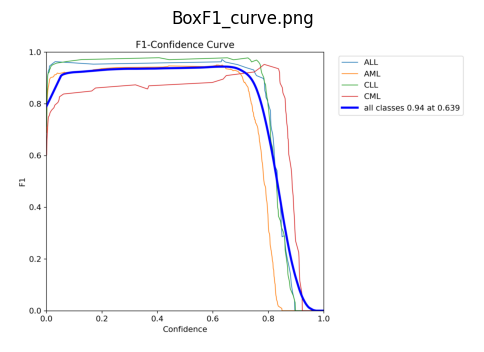

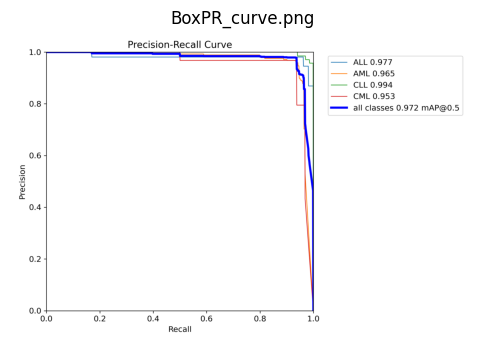

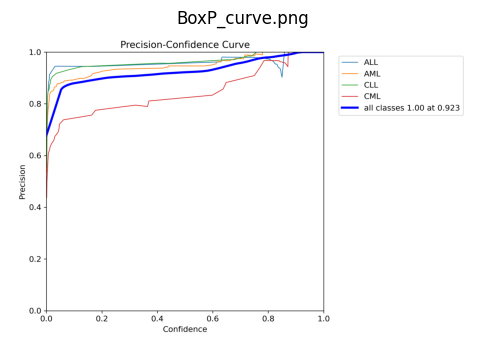

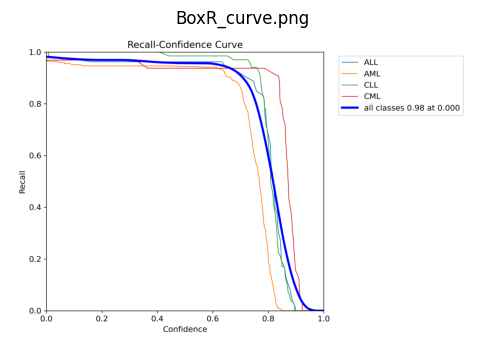

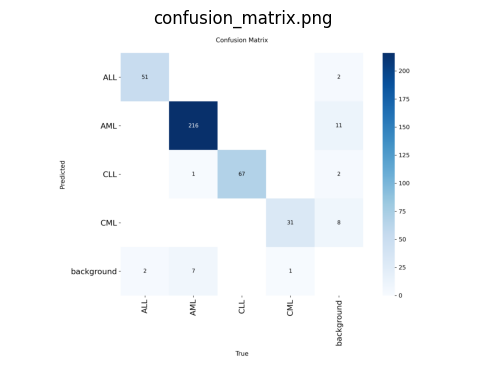

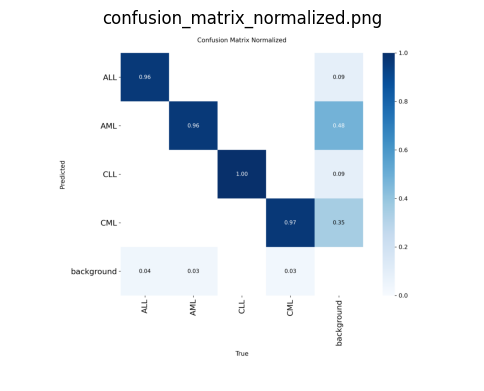

📁 Test results and plots saved in: runs/detect/leukemia_yolo7/test_results\test


In [43]:
from PIL import Image
data_yaml = "data.yaml" 
output_dir = "runs/detect/leukemia_yolo7/test_results"
model_path = "runs/detect/leukemia_yolo7/weights/best.pt"  
model = YOLO(model_path)
os.makedirs(output_dir, exist_ok=True)

results = model.val(
    data=data_yaml,          
    split="test",           
    imgsz=640,              
    batch=16,               
    conf=0.001,             
    iou=0.6,                
    project=output_dir,     
    name="test",            
    save=True,              
    save_txt=True,          
    save_conf=True,         
    plots=True             
)
print("Test Results:")
print(f"Mean Precision: {results.box.mp:.4f}")
print(f"Mean Recall: {results.box.mr:.4f}")
print(f"Mean mAP50: {results.box.map50:.4f}")
print(f"Mean mAP50-95: {results.box.map:.4f}")

with open(os.path.join(output_dir, "test_metrics.txt"), "w") as f:
    f.write(f"Mean Precision: {results.box.mp:.4f}\n")
    f.write(f"Mean Recall: {results.box.mr:.4f}\n")
    f.write(f"Mean mAP50: {results.box.map50:.4f}\n")
    f.write(f"Mean mAP50-95: {results.box.map:.4f}\n")

    %matplotlib inline
plots_folder = os.path.join(output_dir,"test")
plot_images = glob.glob(os.path.join(plots_folder, "*.png"))
for img_path in plot_images:
    img = Image.open(img_path)
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')
    plt.title(os.path.basename(img_path))
    plt.show()

print(f"📁 Test results and plots saved in: {plots_folder}")

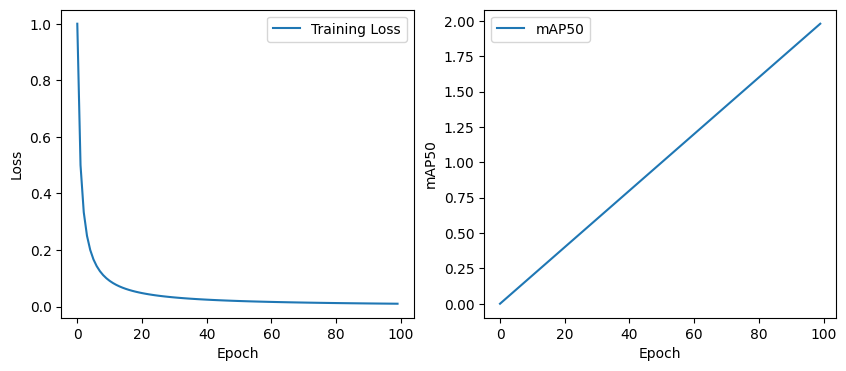

In [40]:
losses, mAPs = [], []
from IPython.display import clear_output

for epoch in range(100):  # replace with your real training loop
    # append dummy values (replace with your trainer metrics)
    losses.append(1/(epoch+1))
    mAPs.append(epoch/50)

    clear_output(wait=True)
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.plot(losses, label="Training Loss")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1,2,2)
    plt.plot(mAPs, label="mAP50")
    plt.legend()
    plt.xlabel("Epoch")
    plt.ylabel("mAP50")

    plt.show()

   epoch      time  train/box_loss  train/cls_loss  train/dfl_loss  \
0      1   329.715         1.89134         2.92481         1.54973   
1      2   661.264         1.82893         1.58287         1.39465   
2      3   985.564         1.74060         1.28923         1.36984   
3      4  1311.700         1.73525         1.16170         1.35601   
4      5  1636.680         1.70306         1.05207         1.32294   

   metrics/precision(B)  metrics/recall(B)  metrics/mAP50(B)  \
0               0.00034            0.00975           0.00060   
1               0.29423            0.07417           0.15288   
2               0.89456            0.57417           0.83603   
3               0.74787            0.70611           0.73385   
4               0.72605            0.84452           0.91088   

   metrics/mAP50-95(B)  val/box_loss  val/cls_loss  val/dfl_loss    lr/pg0  \
0              0.00033       2.75902       4.53620       2.80093  0.076240   
1              0.07330       1.91745  

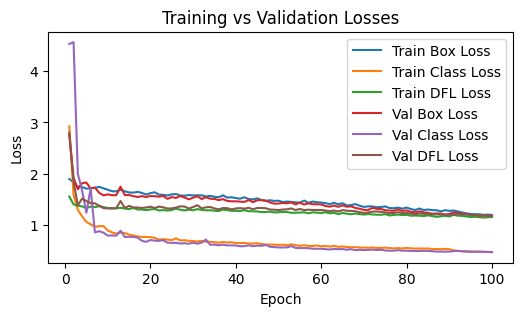

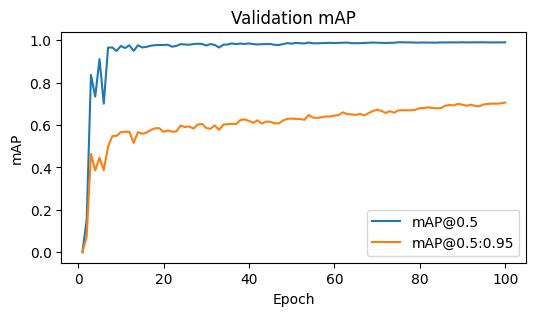

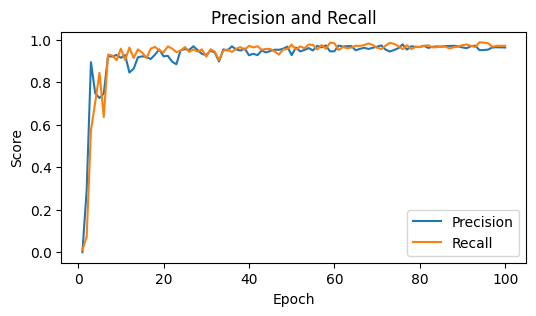

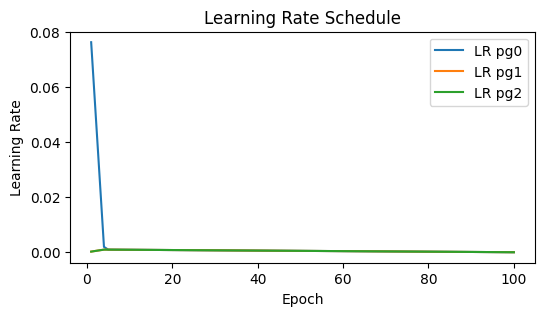

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load training results
df = pd.read_csv("runs/detect/leukemia_yolo7/results.csv")

# Show first few rows
print(df.head())

# ---------------------------
# Plot Training & Validation Losses
# ---------------------------
plt.figure(figsize=(6,3))
plt.plot(df["epoch"], df["train/box_loss"], label="Train Box Loss")
plt.plot(df["epoch"], df["train/cls_loss"], label="Train Class Loss")
plt.plot(df["epoch"], df["train/dfl_loss"], label="Train DFL Loss")
plt.plot(df["epoch"], df["val/box_loss"], label="Val Box Loss")
plt.plot(df["epoch"], df["val/cls_loss"], label="Val Class Loss")
plt.plot(df["epoch"], df["val/dfl_loss"], label="Val DFL Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Losses")
plt.legend()
plt.show()

# ---------------------------
# Plot mAP (Performance Metrics)
# ---------------------------
plt.figure(figsize=(6,3))
plt.plot(df["epoch"], df["metrics/mAP50(B)"], label="mAP@0.5")
plt.plot(df["epoch"], df["metrics/mAP50-95(B)"], label="mAP@0.5:0.95")
plt.xlabel("Epoch")
plt.ylabel("mAP")
plt.title("Validation mAP")
plt.legend()
plt.show()

# ---------------------------
# Plot Precision & Recall
# ---------------------------
plt.figure(figsize=(6,3))
plt.plot(df["epoch"], df["metrics/precision(B)"], label="Precision")
plt.plot(df["epoch"], df["metrics/recall(B)"], label="Recall")
plt.xlabel("Epoch")
plt.ylabel("Score")
plt.title("Precision and Recall")
plt.legend()
plt.show()

# ---------------------------
# Plot Learning Rate
# ---------------------------
plt.figure(figsize=(6,3))
plt.plot(df["epoch"], df["lr/pg0"], label="LR pg0")
plt.plot(df["epoch"], df["lr/pg1"], label="LR pg1")
plt.plot(df["epoch"], df["lr/pg2"], label="LR pg2")
plt.xlabel("Epoch")
plt.ylabel("Learning Rate")
plt.title("Learning Rate Schedule")
plt.legend()
plt.show()


In [37]:
from ultralytics import YOLO
import cv2

# 1. Load your trained model
model1 = YOLO("runs/detect/leukemia_yolo7/weights/best.pt")

# 2. Run prediction on an image
results = model1("D:\\Dataset Lukemia\\Project\\final_dataset\\WBC\\20181230_142128.jpg")   # you can also use a folder or list of images

# 3. Show results
result = results[0]  # opens a window with detections drawn
result.show()
# 4. Save results to a folder
result.save("predictions/")   # saves annotated images

# 5. Access raw results (boxes, classes, confidences)
for r in result:
    boxes = r.boxes.xyxy   # bounding box coordinates (x1, y1, x2, y2)
    confs = r.boxes.conf   # confidence scores
    clss = r.boxes.cls     # predicted class indices
    
    for box, conf, cls in zip(boxes, confs, clss):
        print(f"Class: {model1.names[int(cls)]}, Conf: {conf:.2f}, Box: {box.tolist()}")



image 1/1 D:\Dataset Lukemia\Project\final_dataset\WBC\20181230_142128.jpg: 640x480 3 AMLs, 303.3ms
Speed: 2.9ms preprocess, 303.3ms inference, 1.1ms postprocess per image at shape (1, 3, 640, 480)
Class: AML, Conf: 0.71, Box: [1546.28564453125, 3277.77880859375, 1889.764892578125, 3660.450439453125]
Class: AML, Conf: 0.49, Box: [152.80548095703125, 3032.087646484375, 520.6720581054688, 3405.4677734375]
Class: AML, Conf: 0.34, Box: [1797.84423828125, 3244.170654296875, 2230.935302734375, 3722.425048828125]


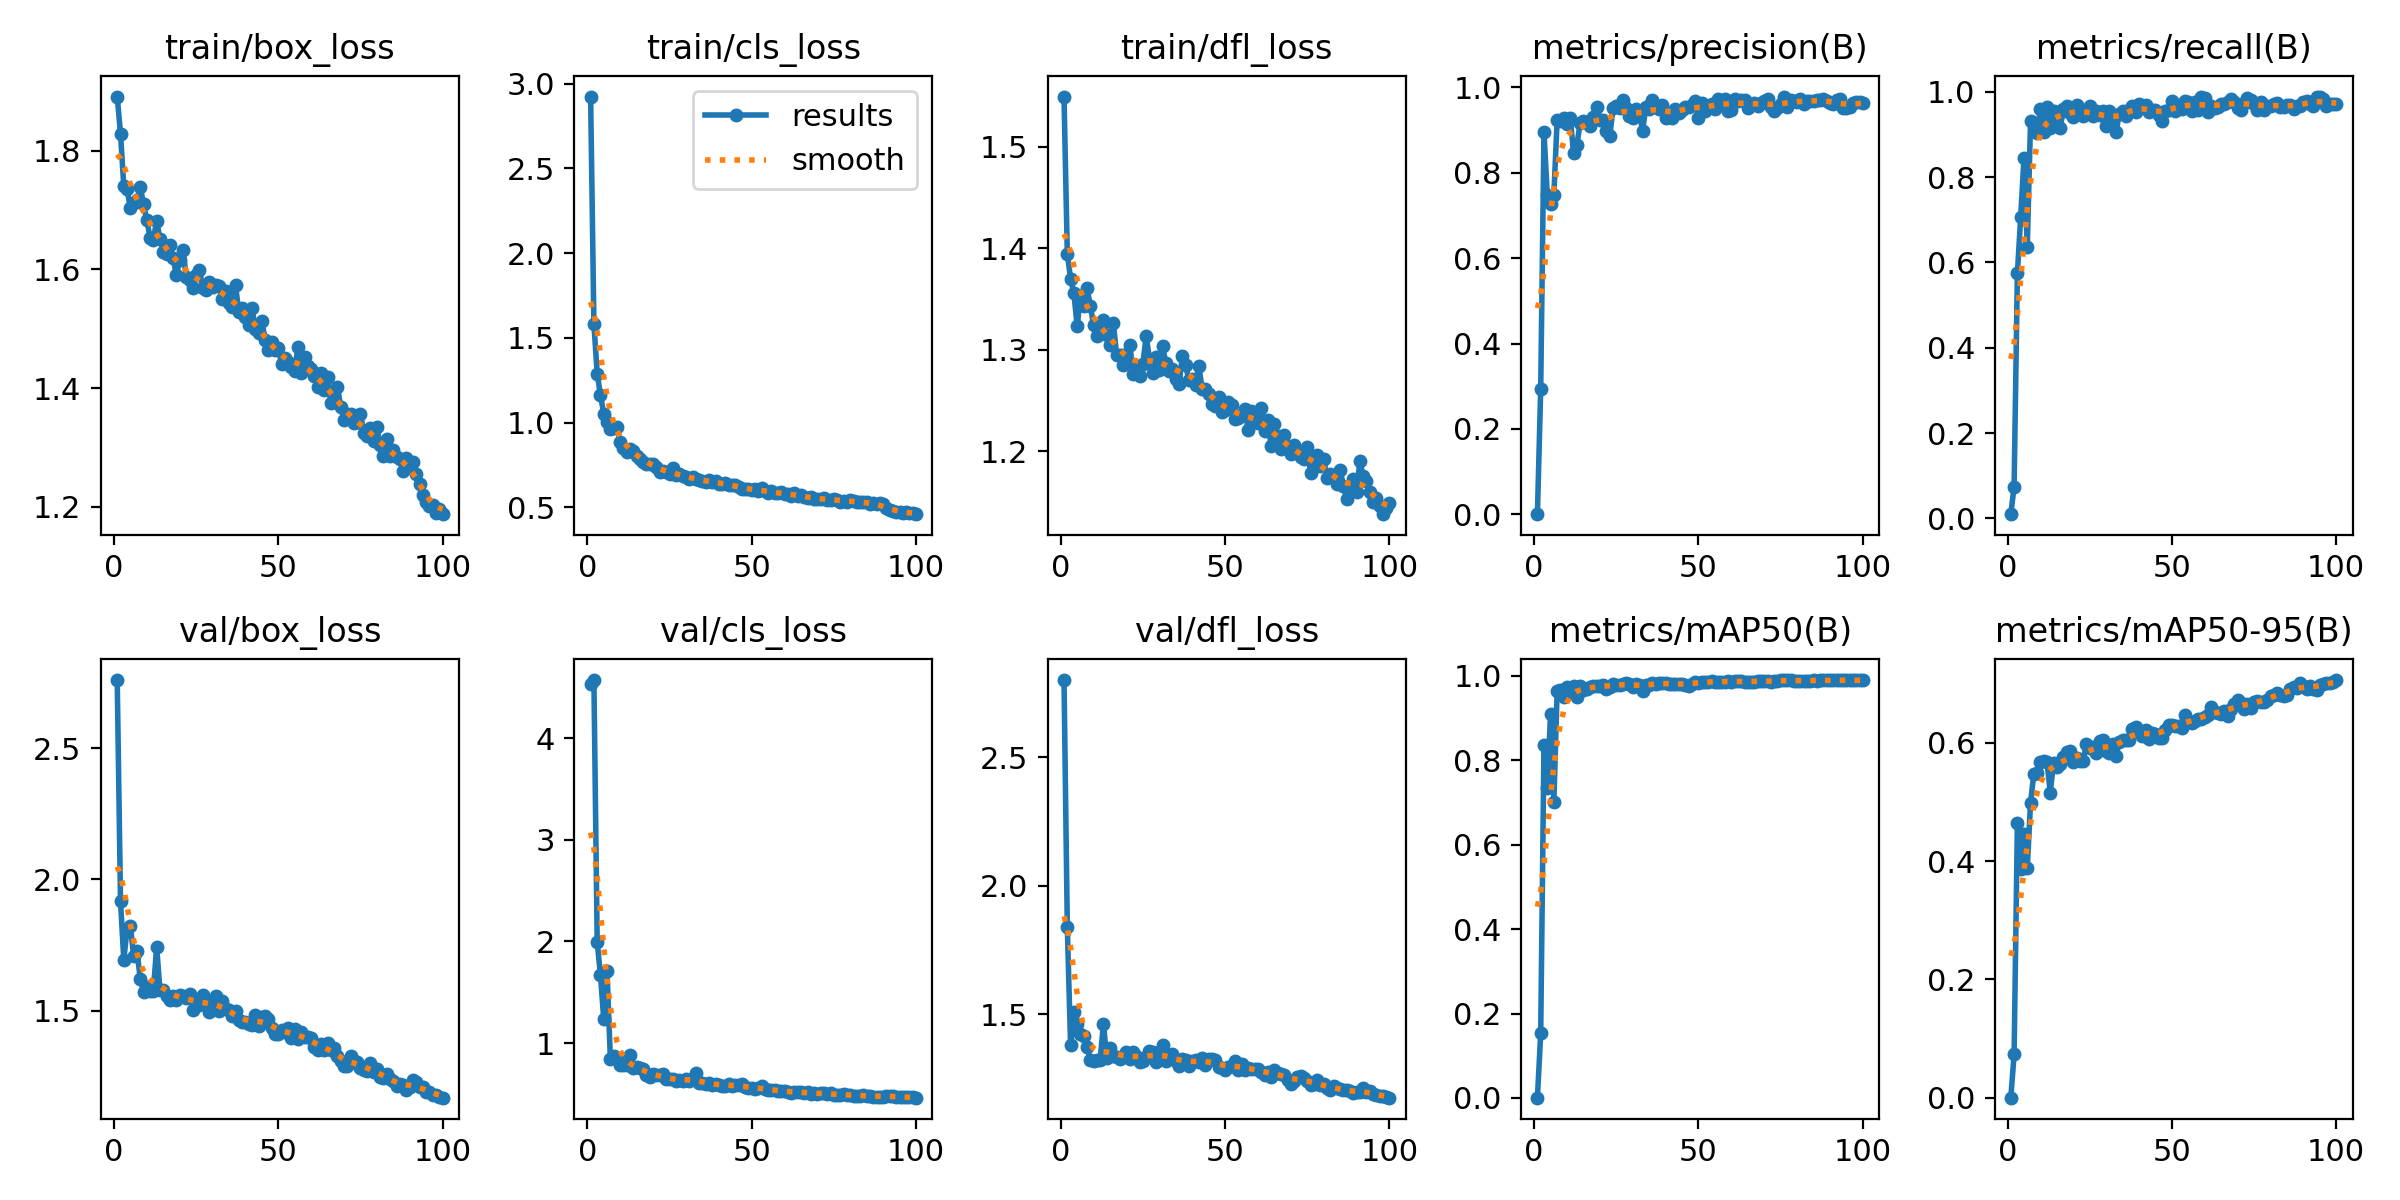

In [44]:
from IPython.display import Image, display

# Show YOLO training curves
display(Image(filename="runs/detect/leukemia_yolo7/results.png"))

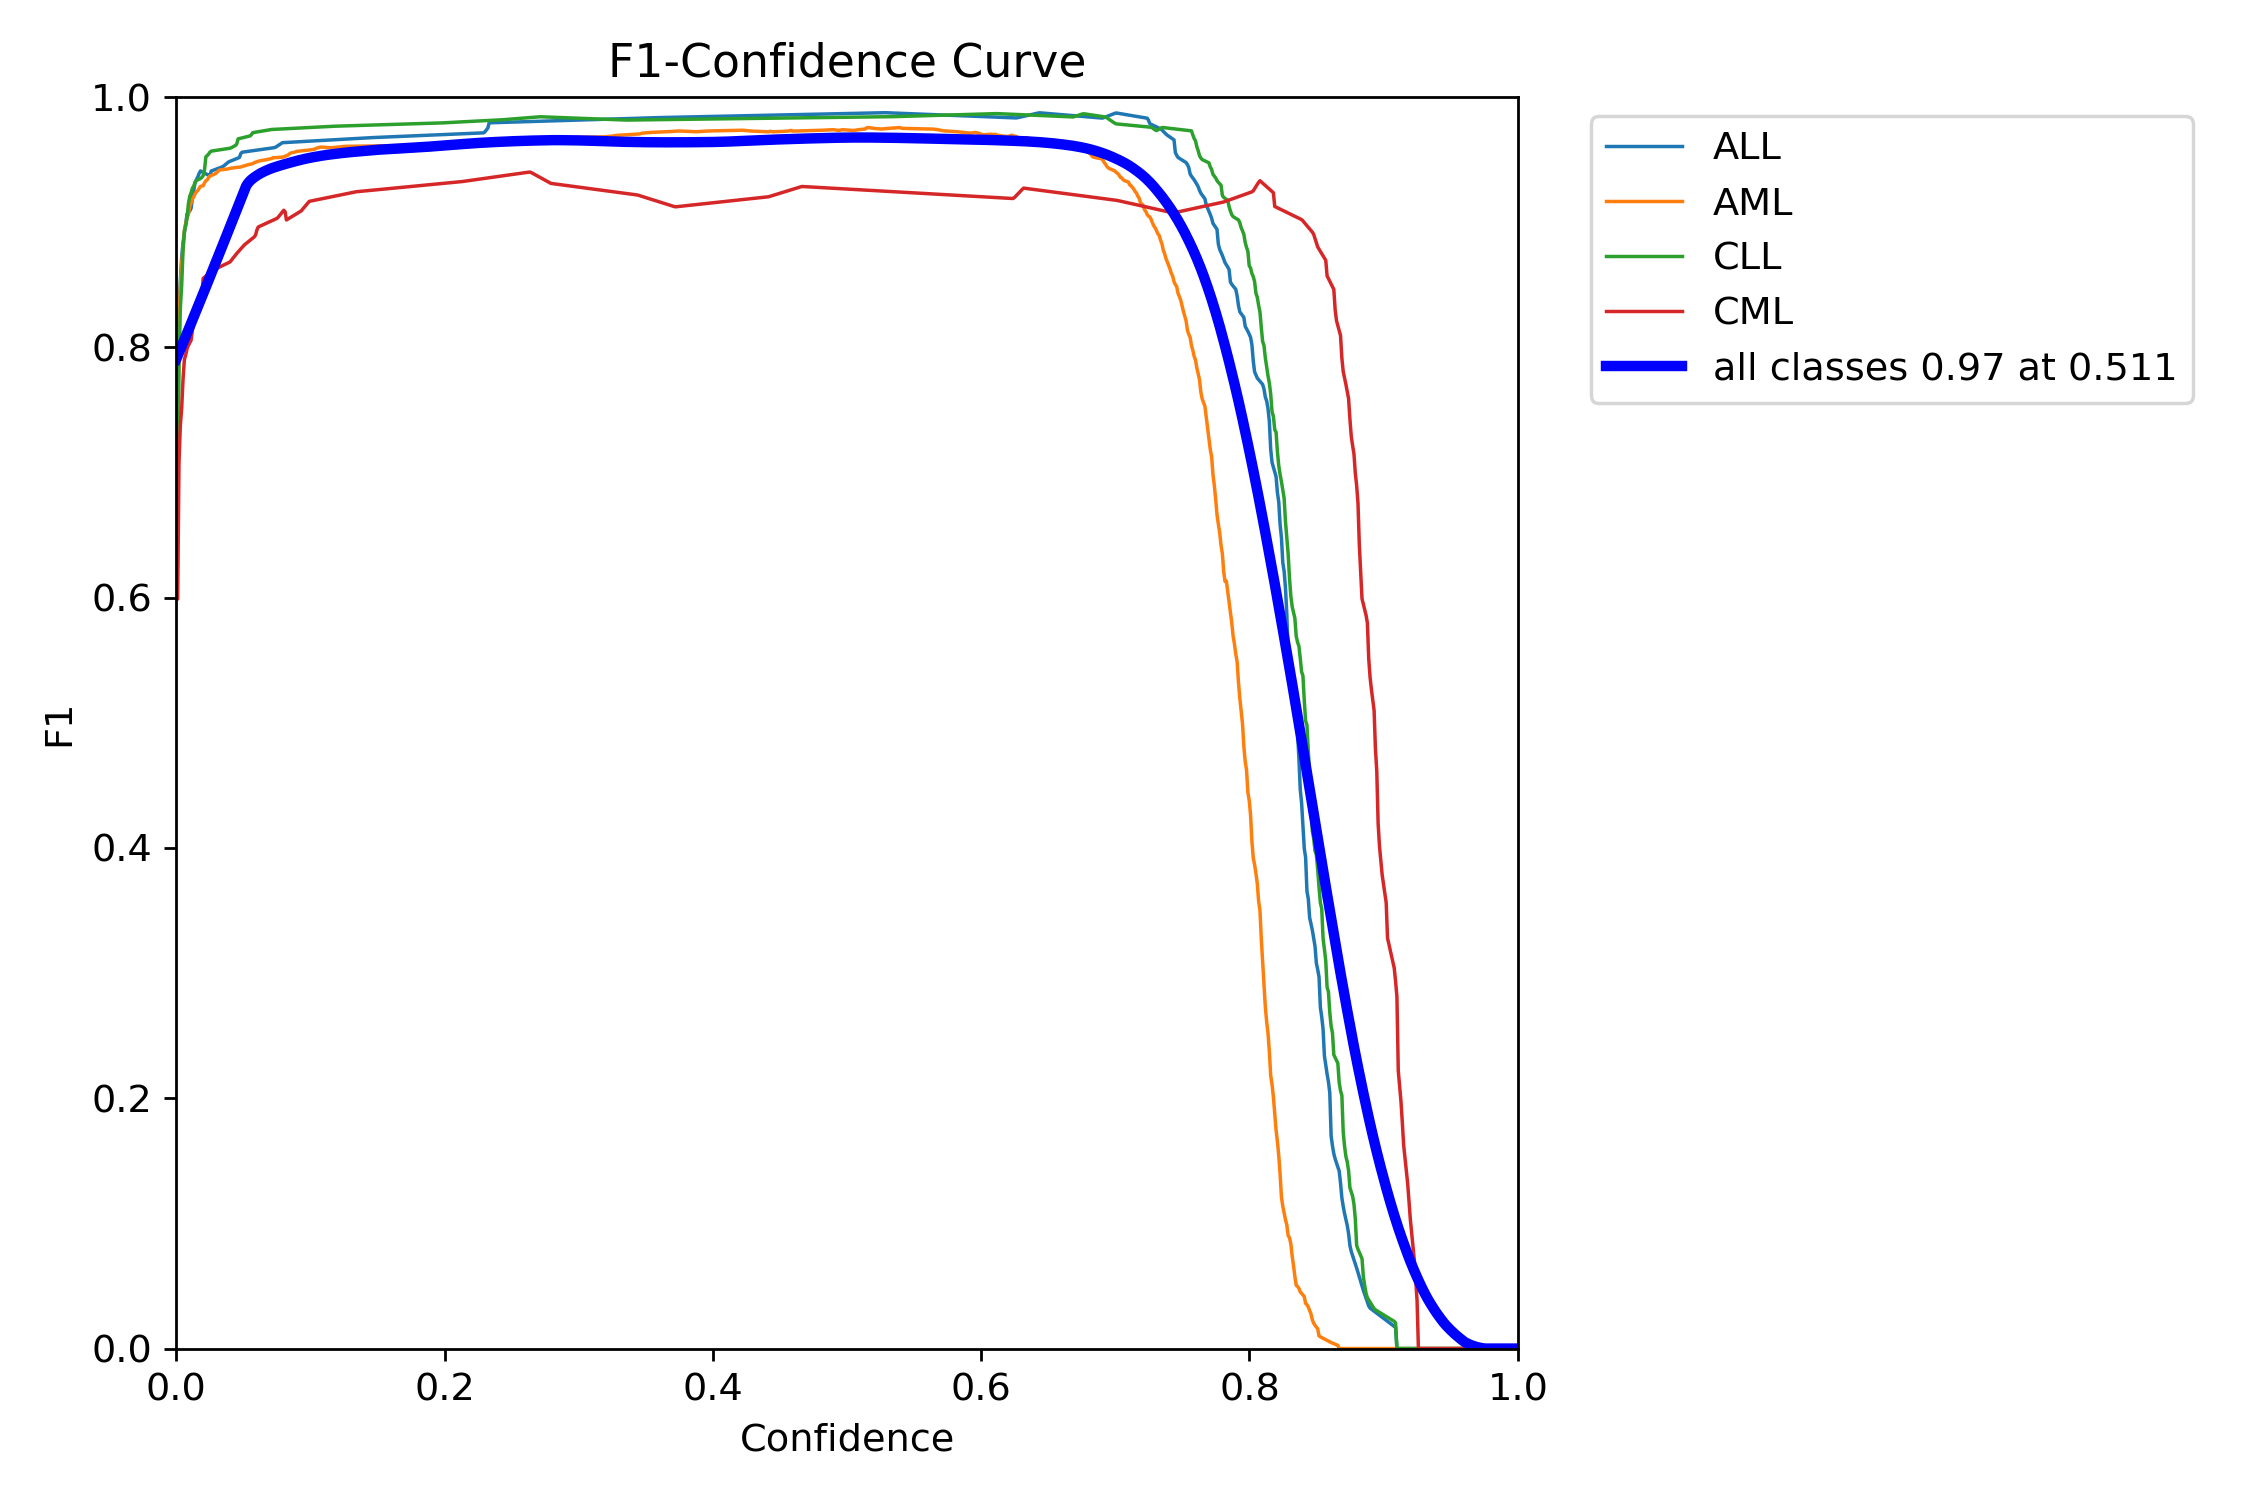

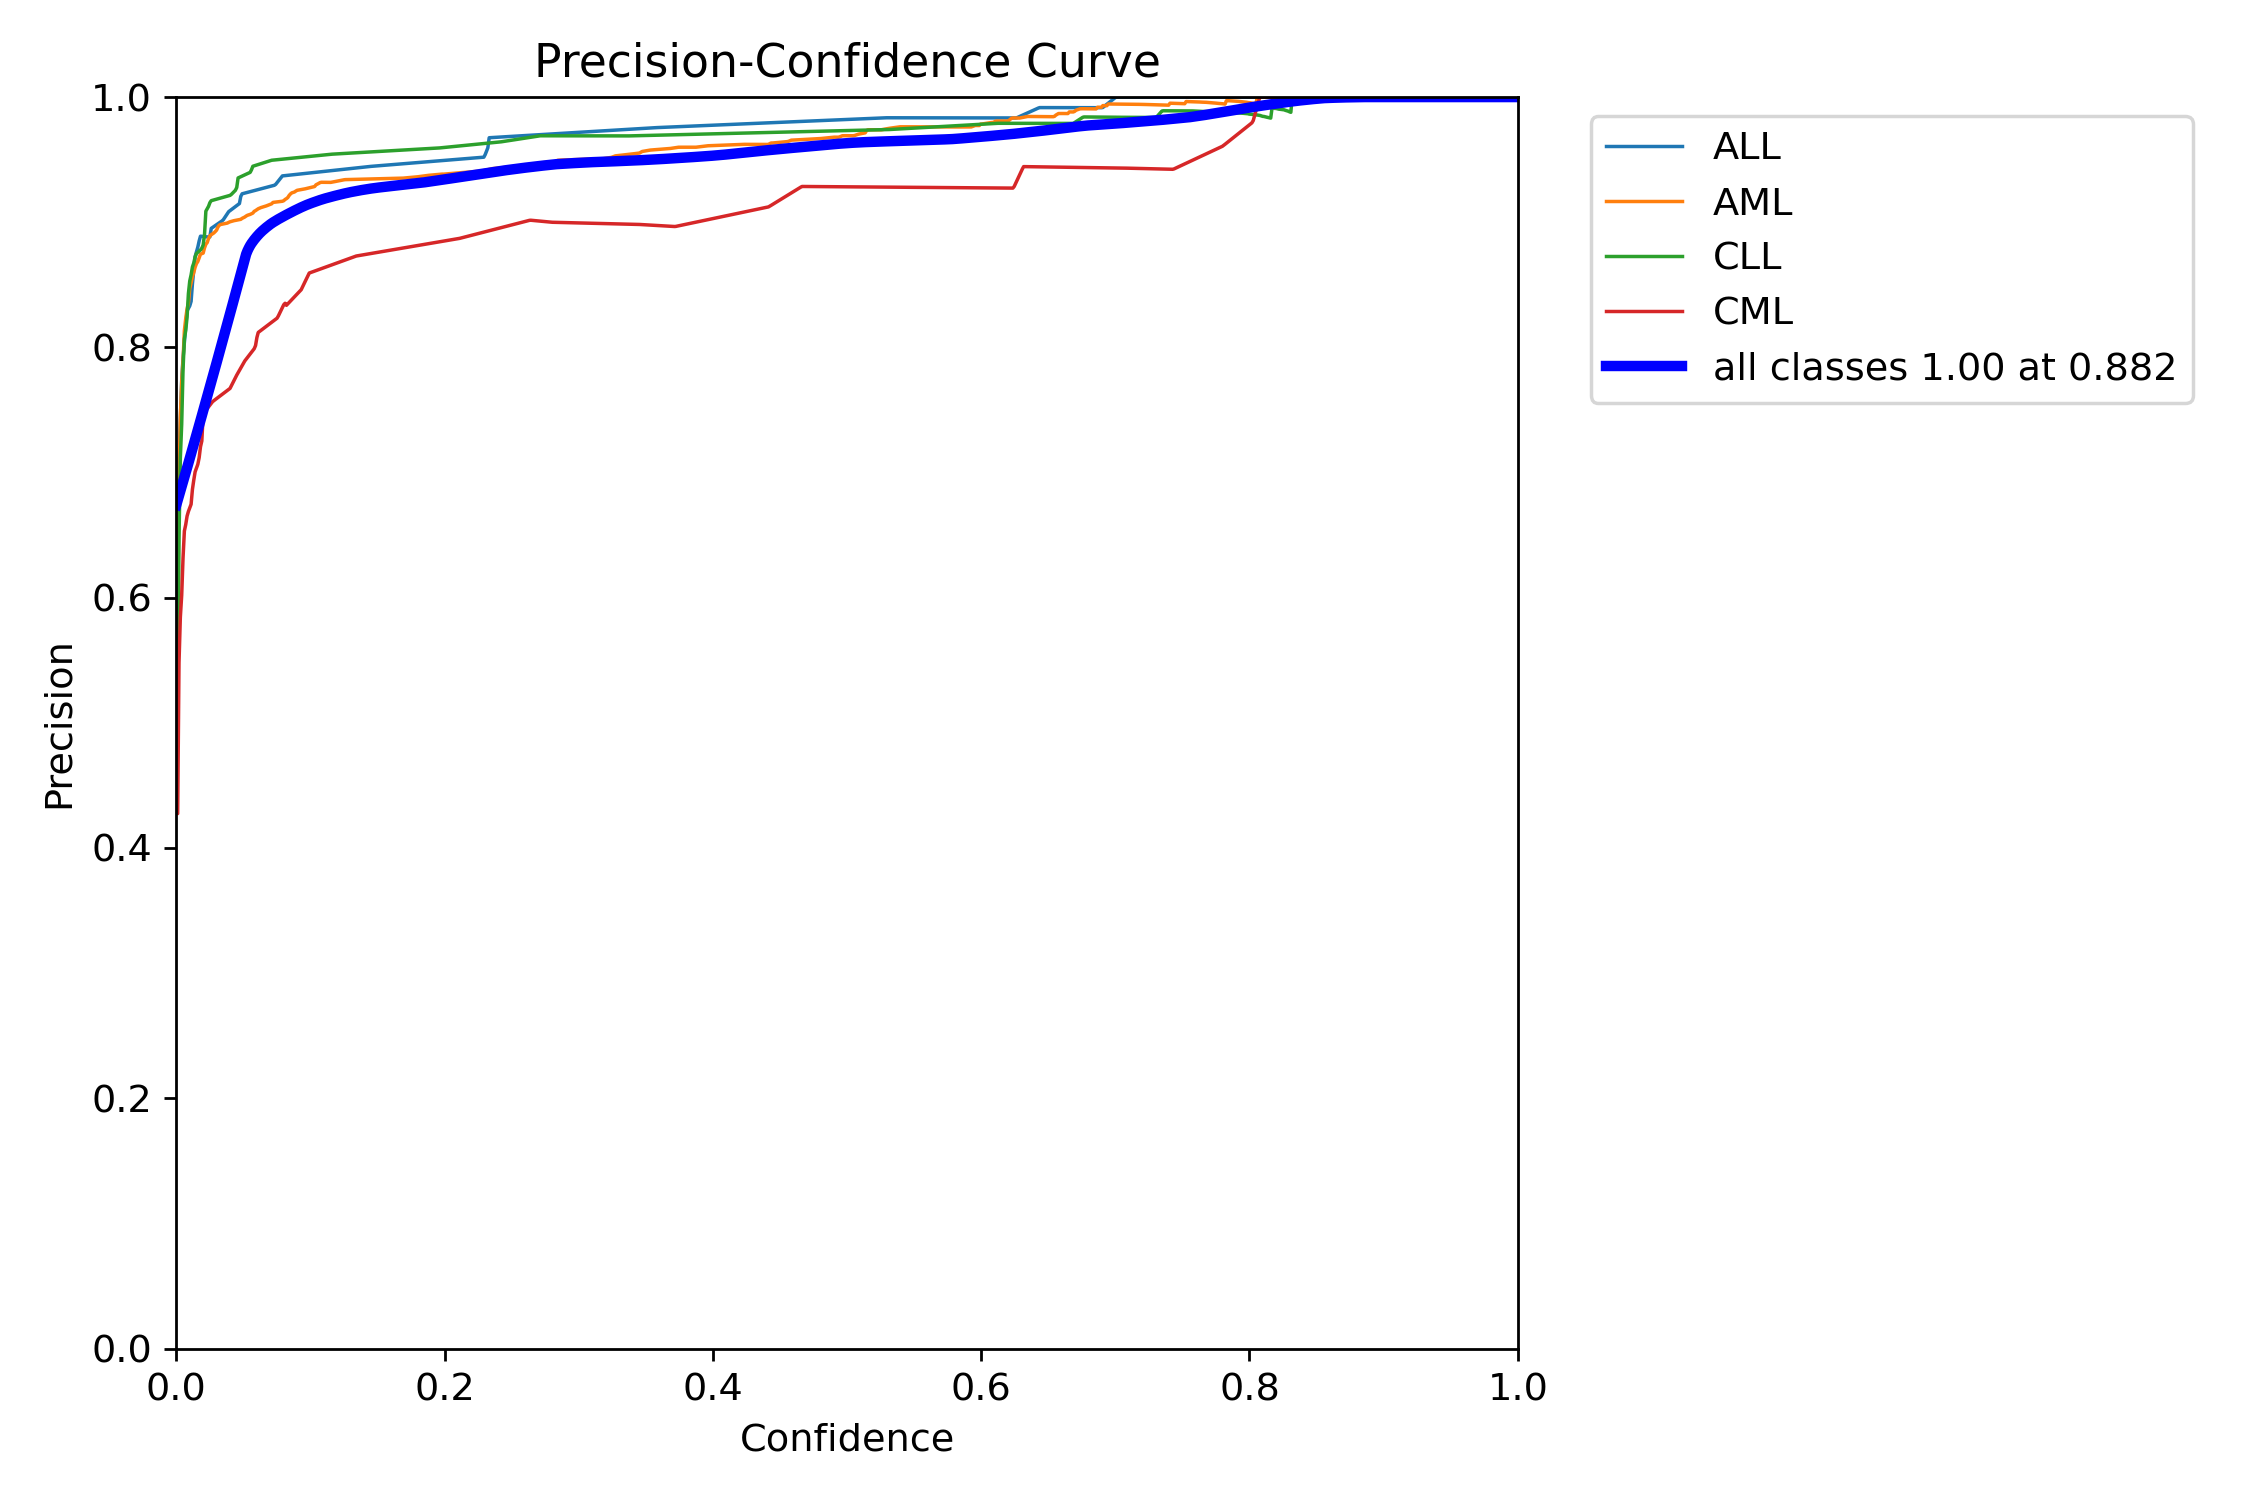

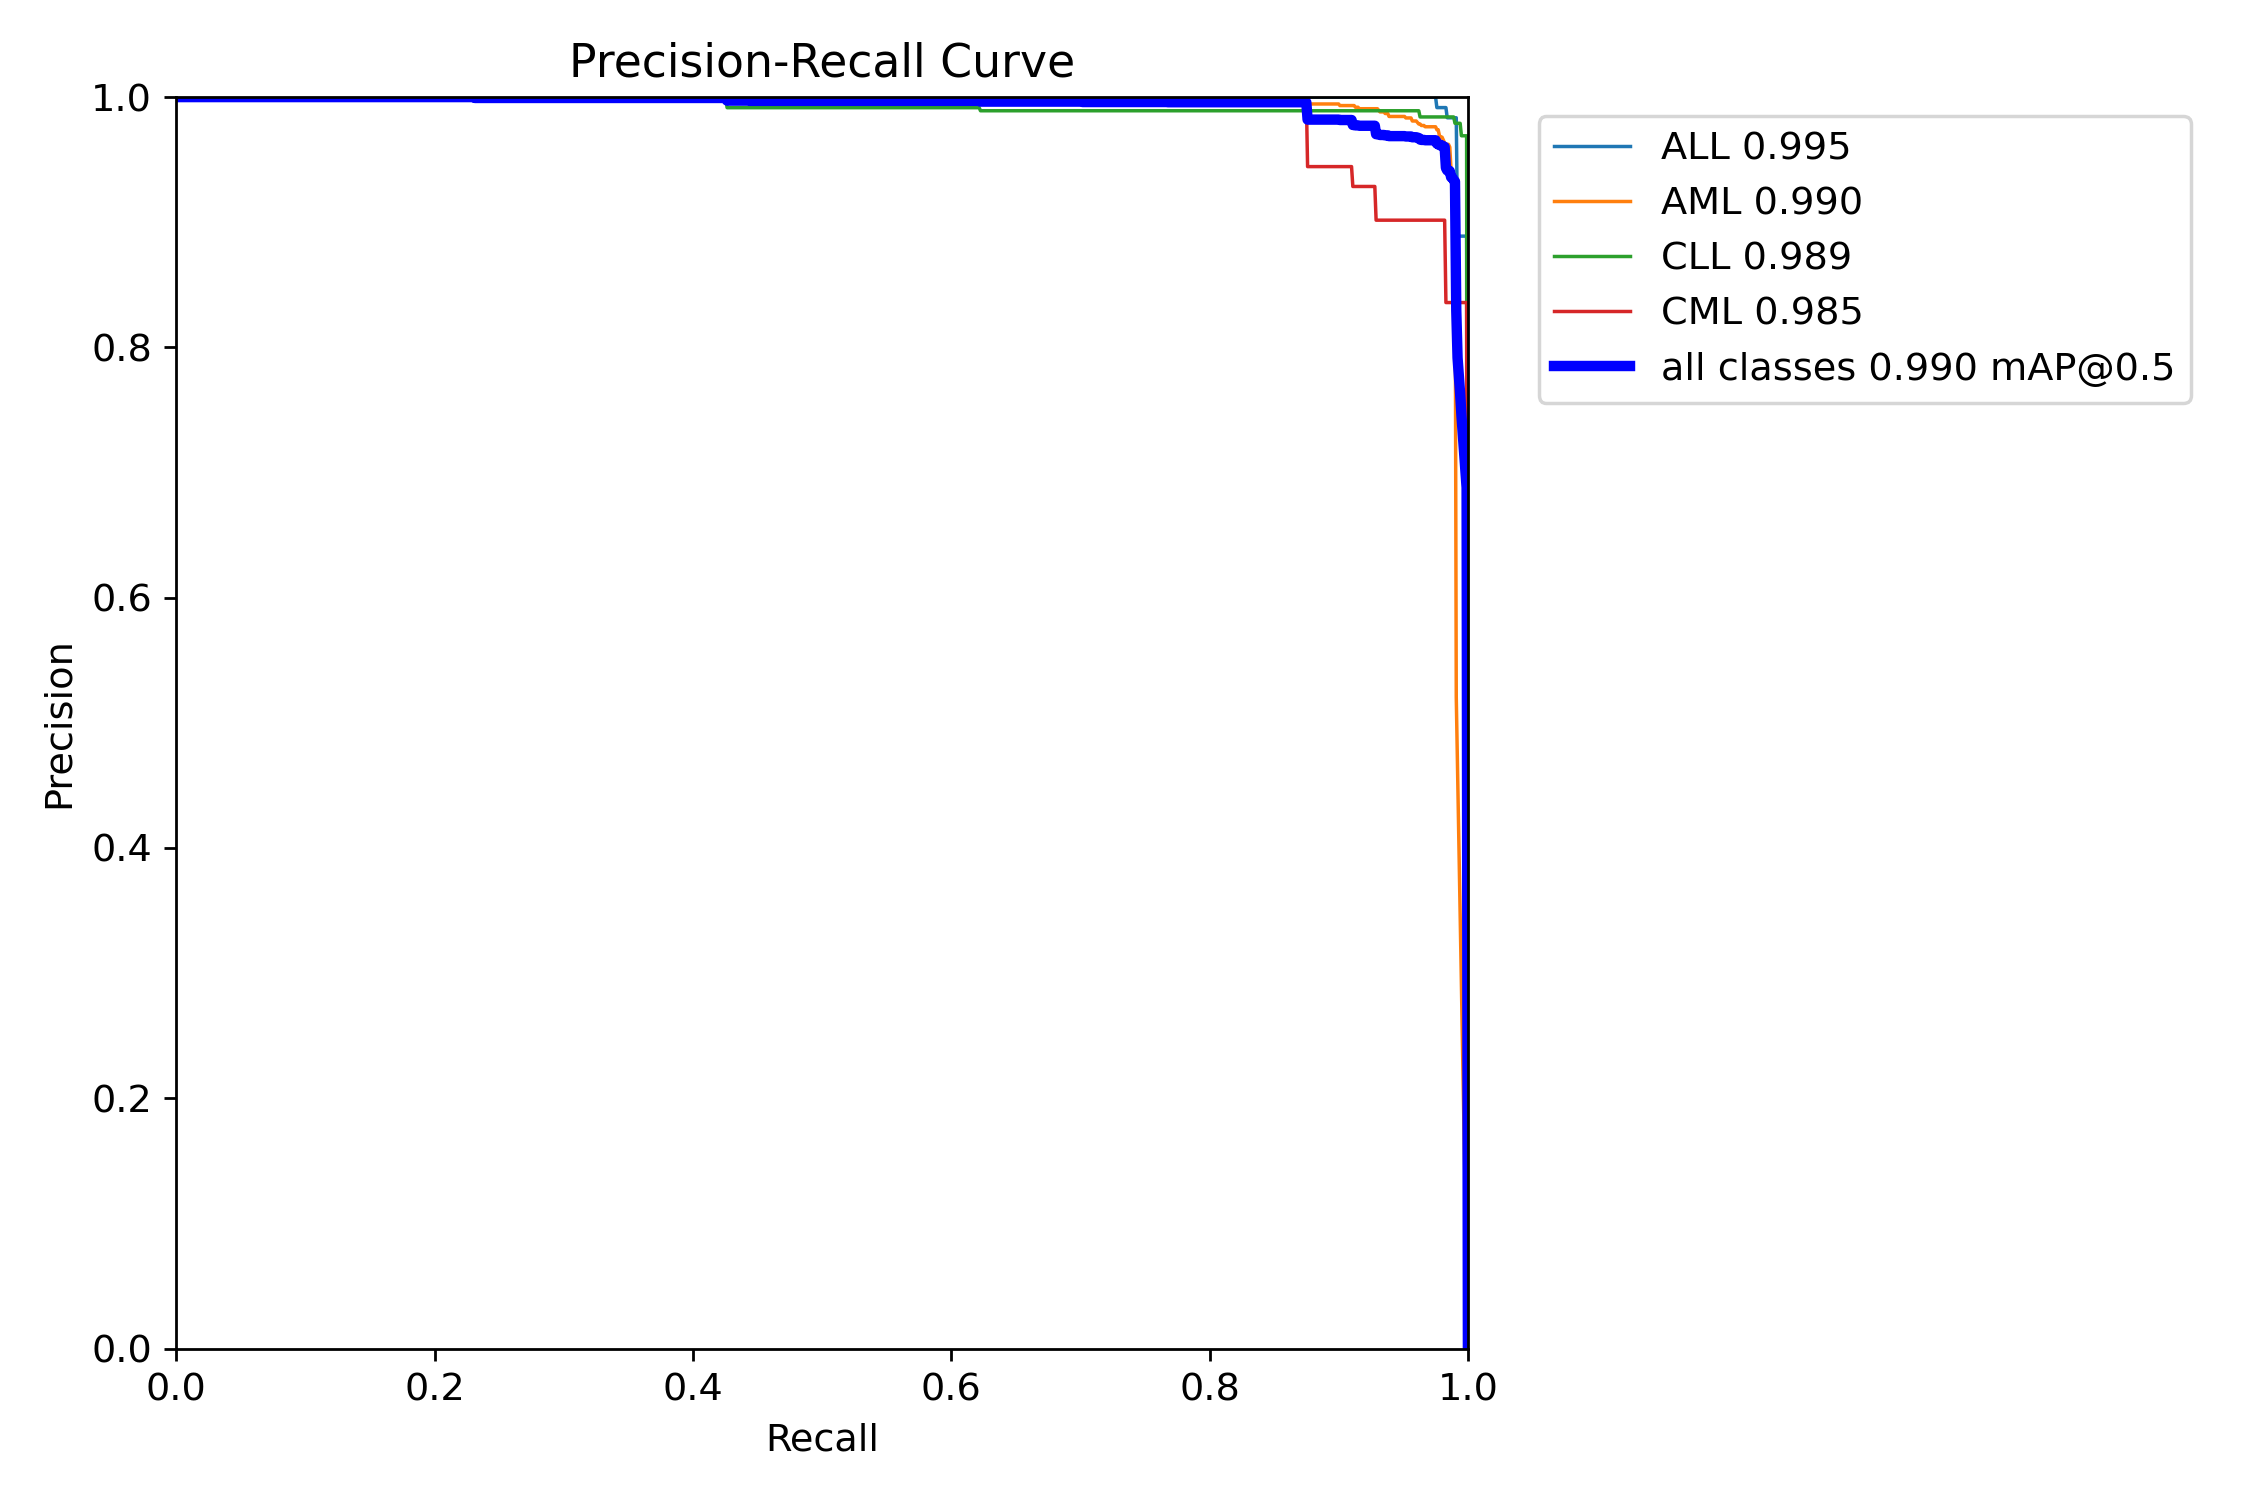

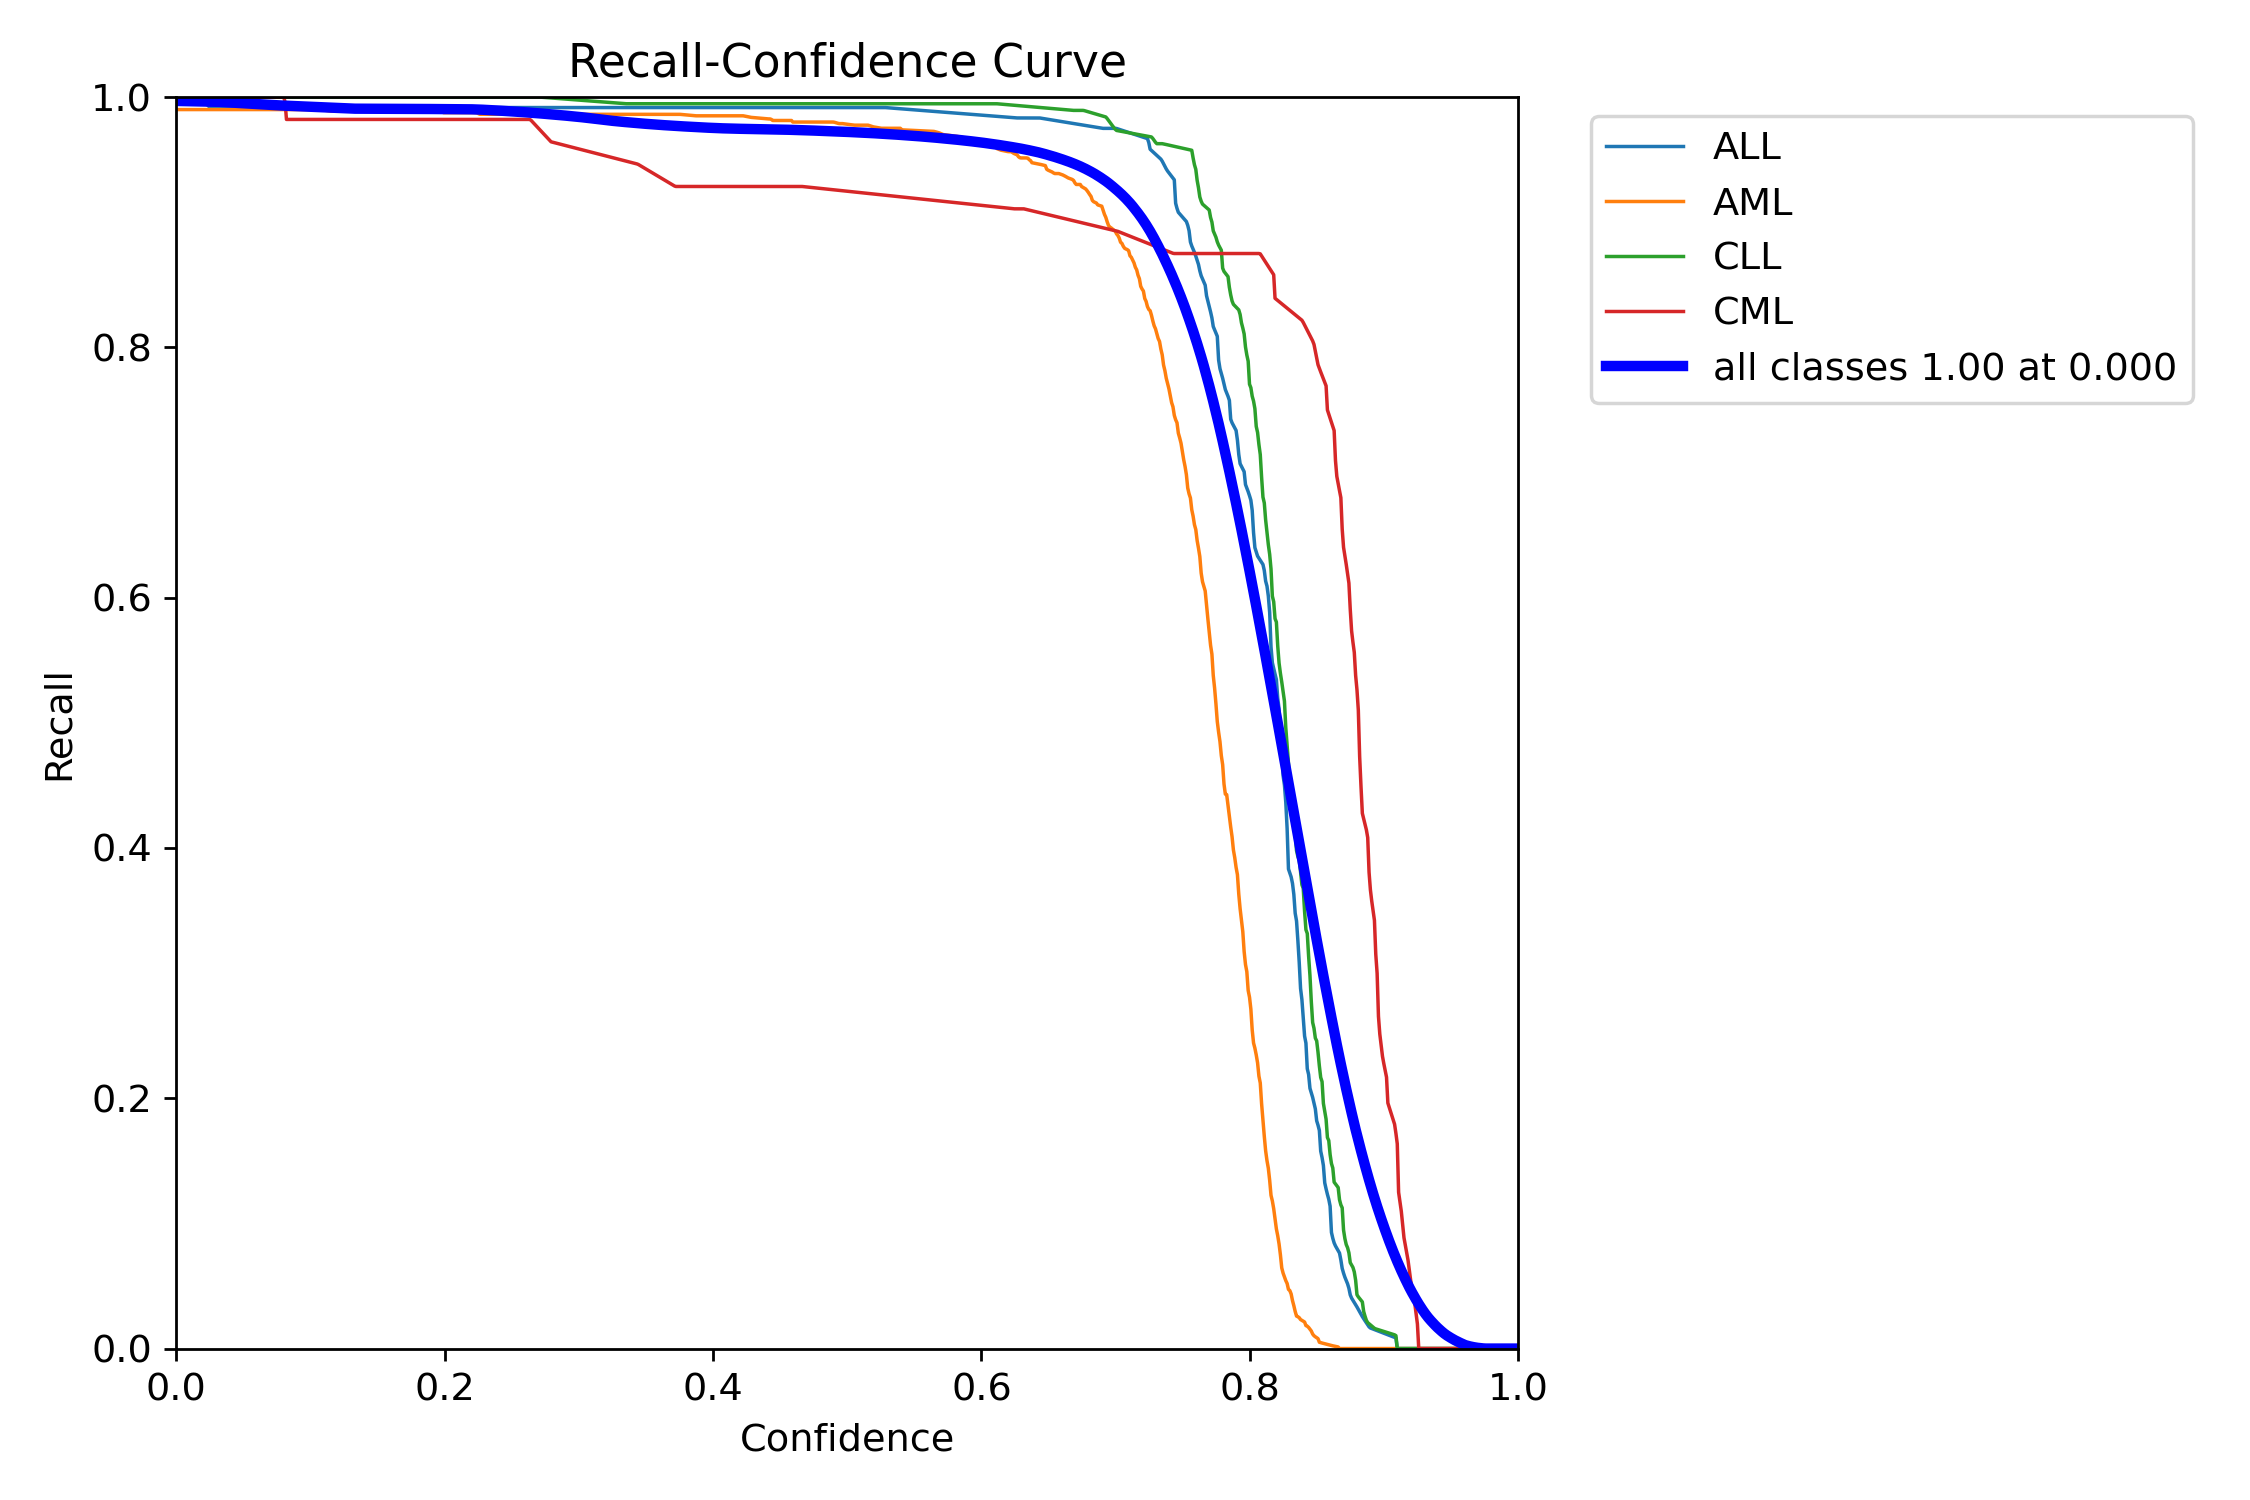

In [45]:
display(Image(filename="runs/detect/leukemia_yolo7/BoxF1_curve.png"))
display(Image(filename="runs/detect/leukemia_yolo7/BoxP_curve.png"))
display(Image(filename="runs/detect/leukemia_yolo7/BoxPR_curve.png"))
display(Image(filename="runs/detect/leukemia_yolo7/BoxR_curve.png"))

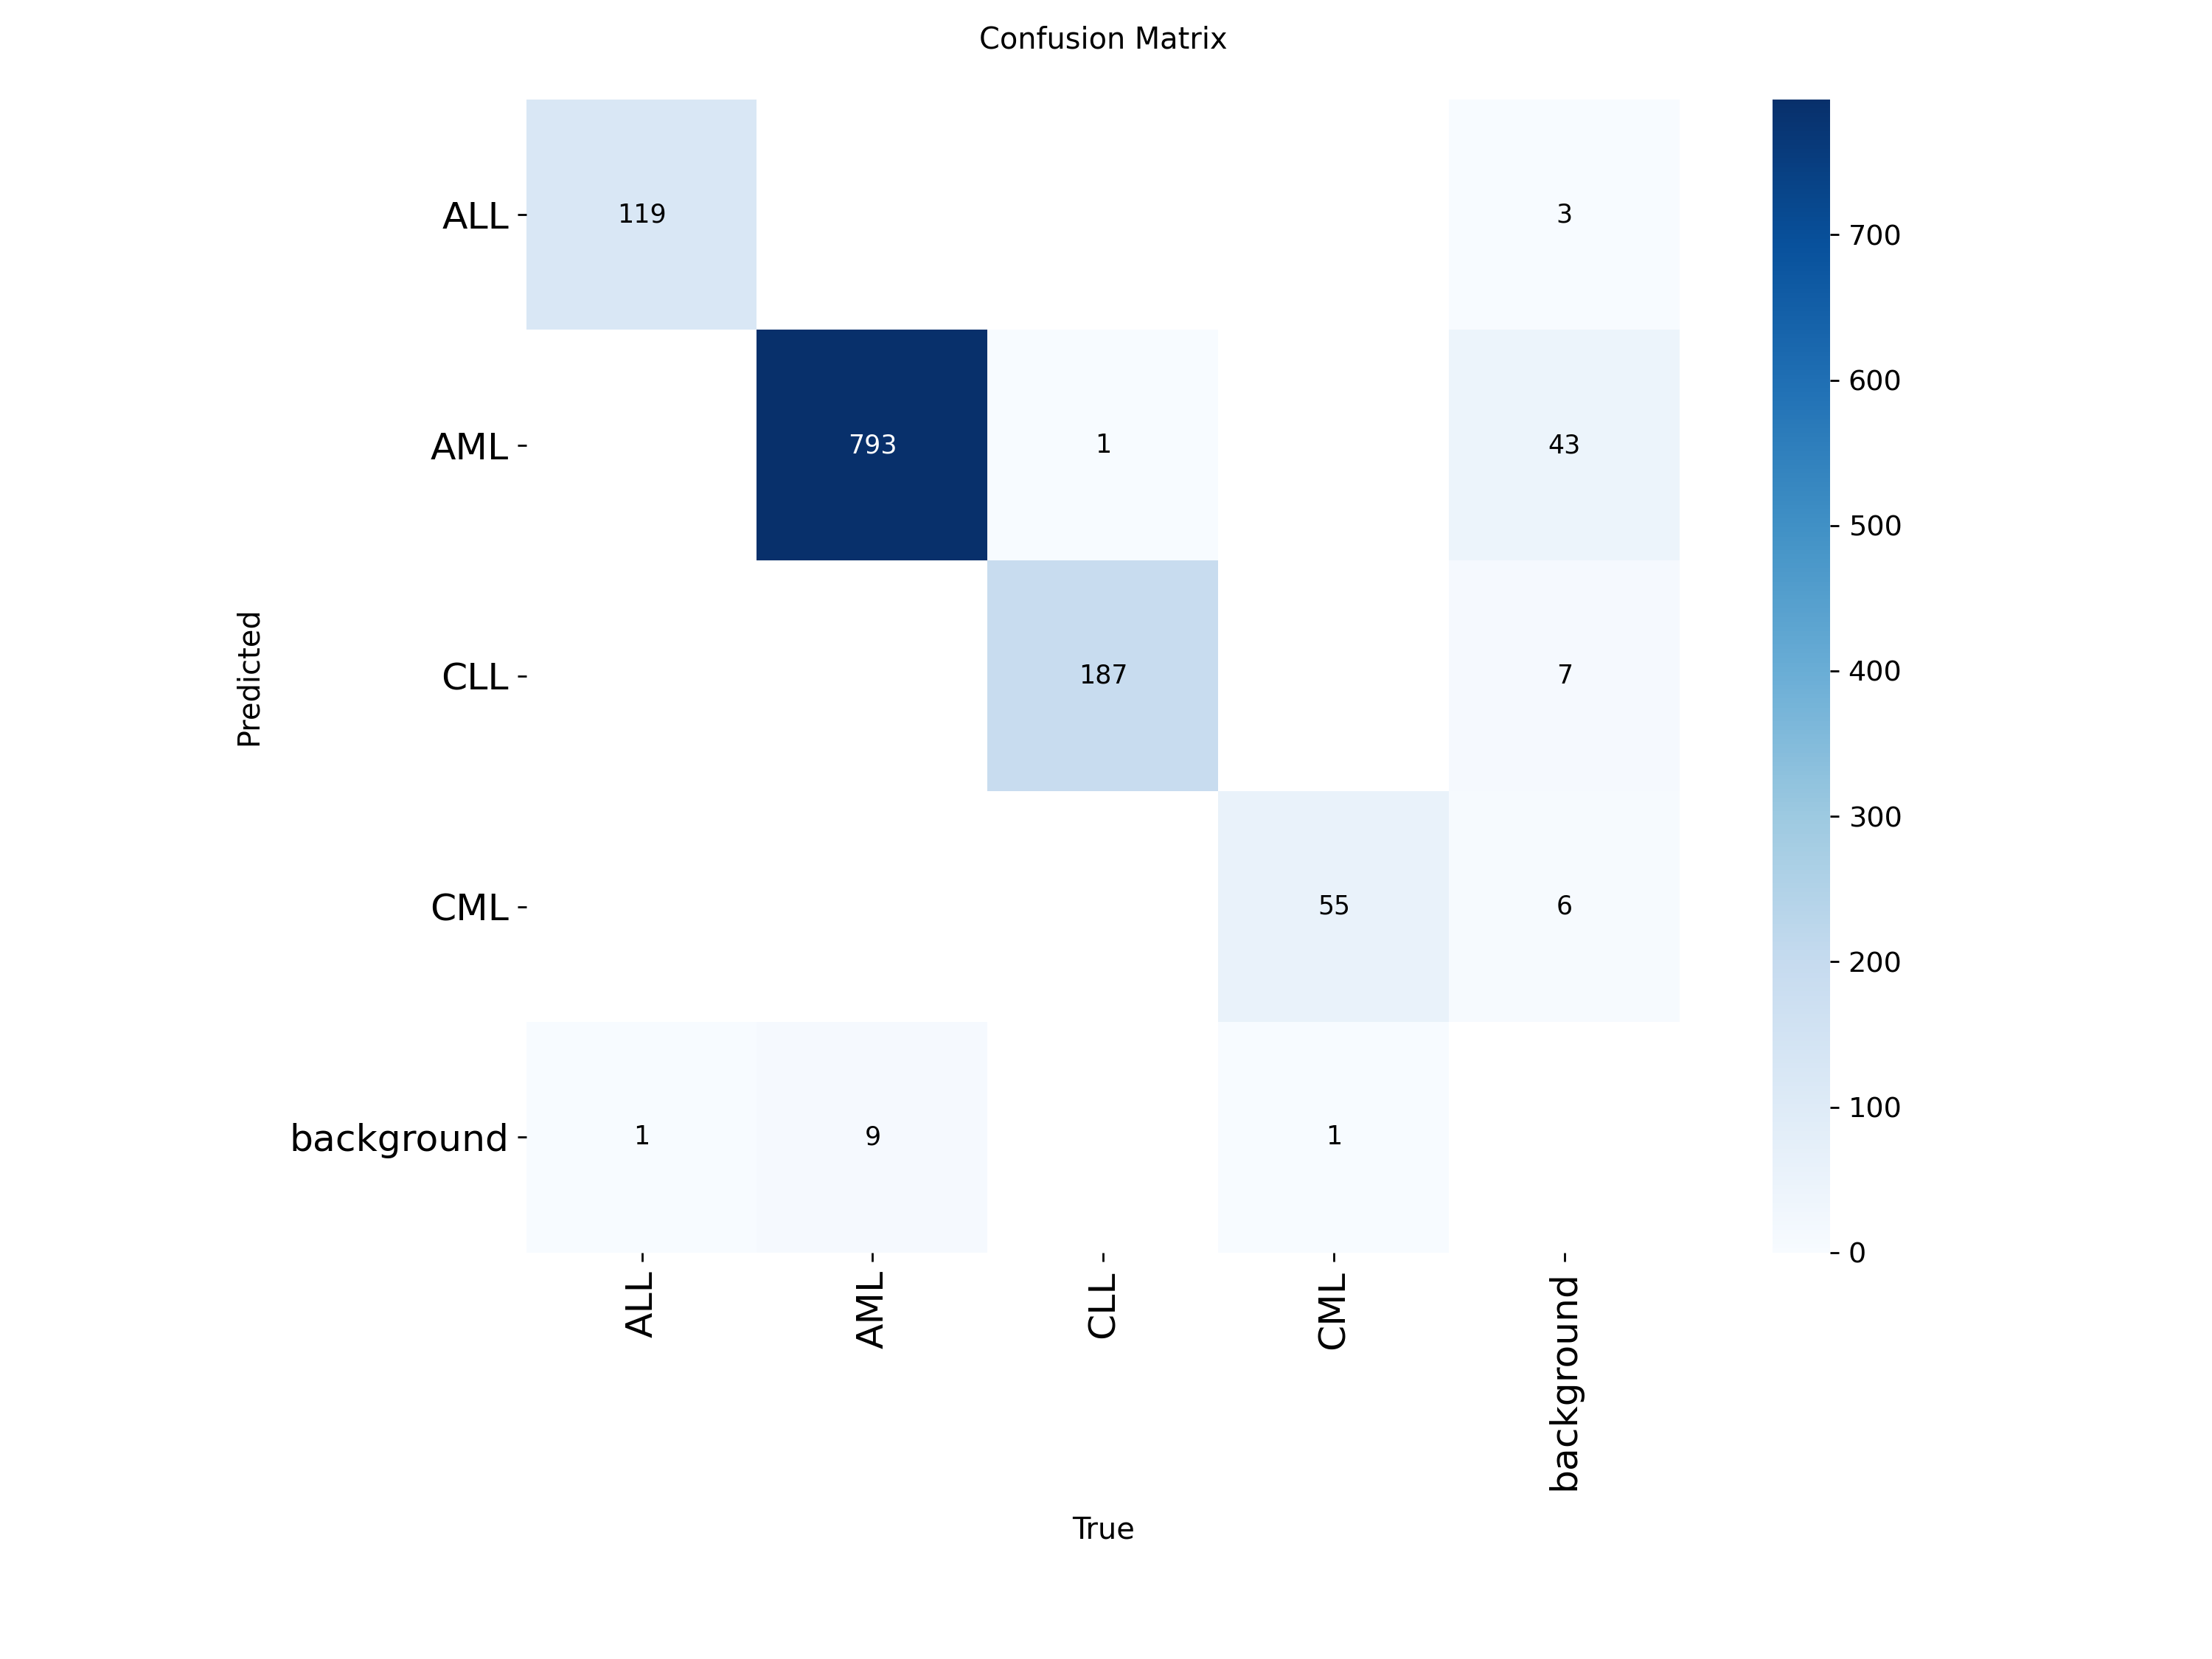

In [47]:
# Show example validation predictions
display(Image(filename="runs/detect/leukemia_yolo7/confusion_matrix.png"))


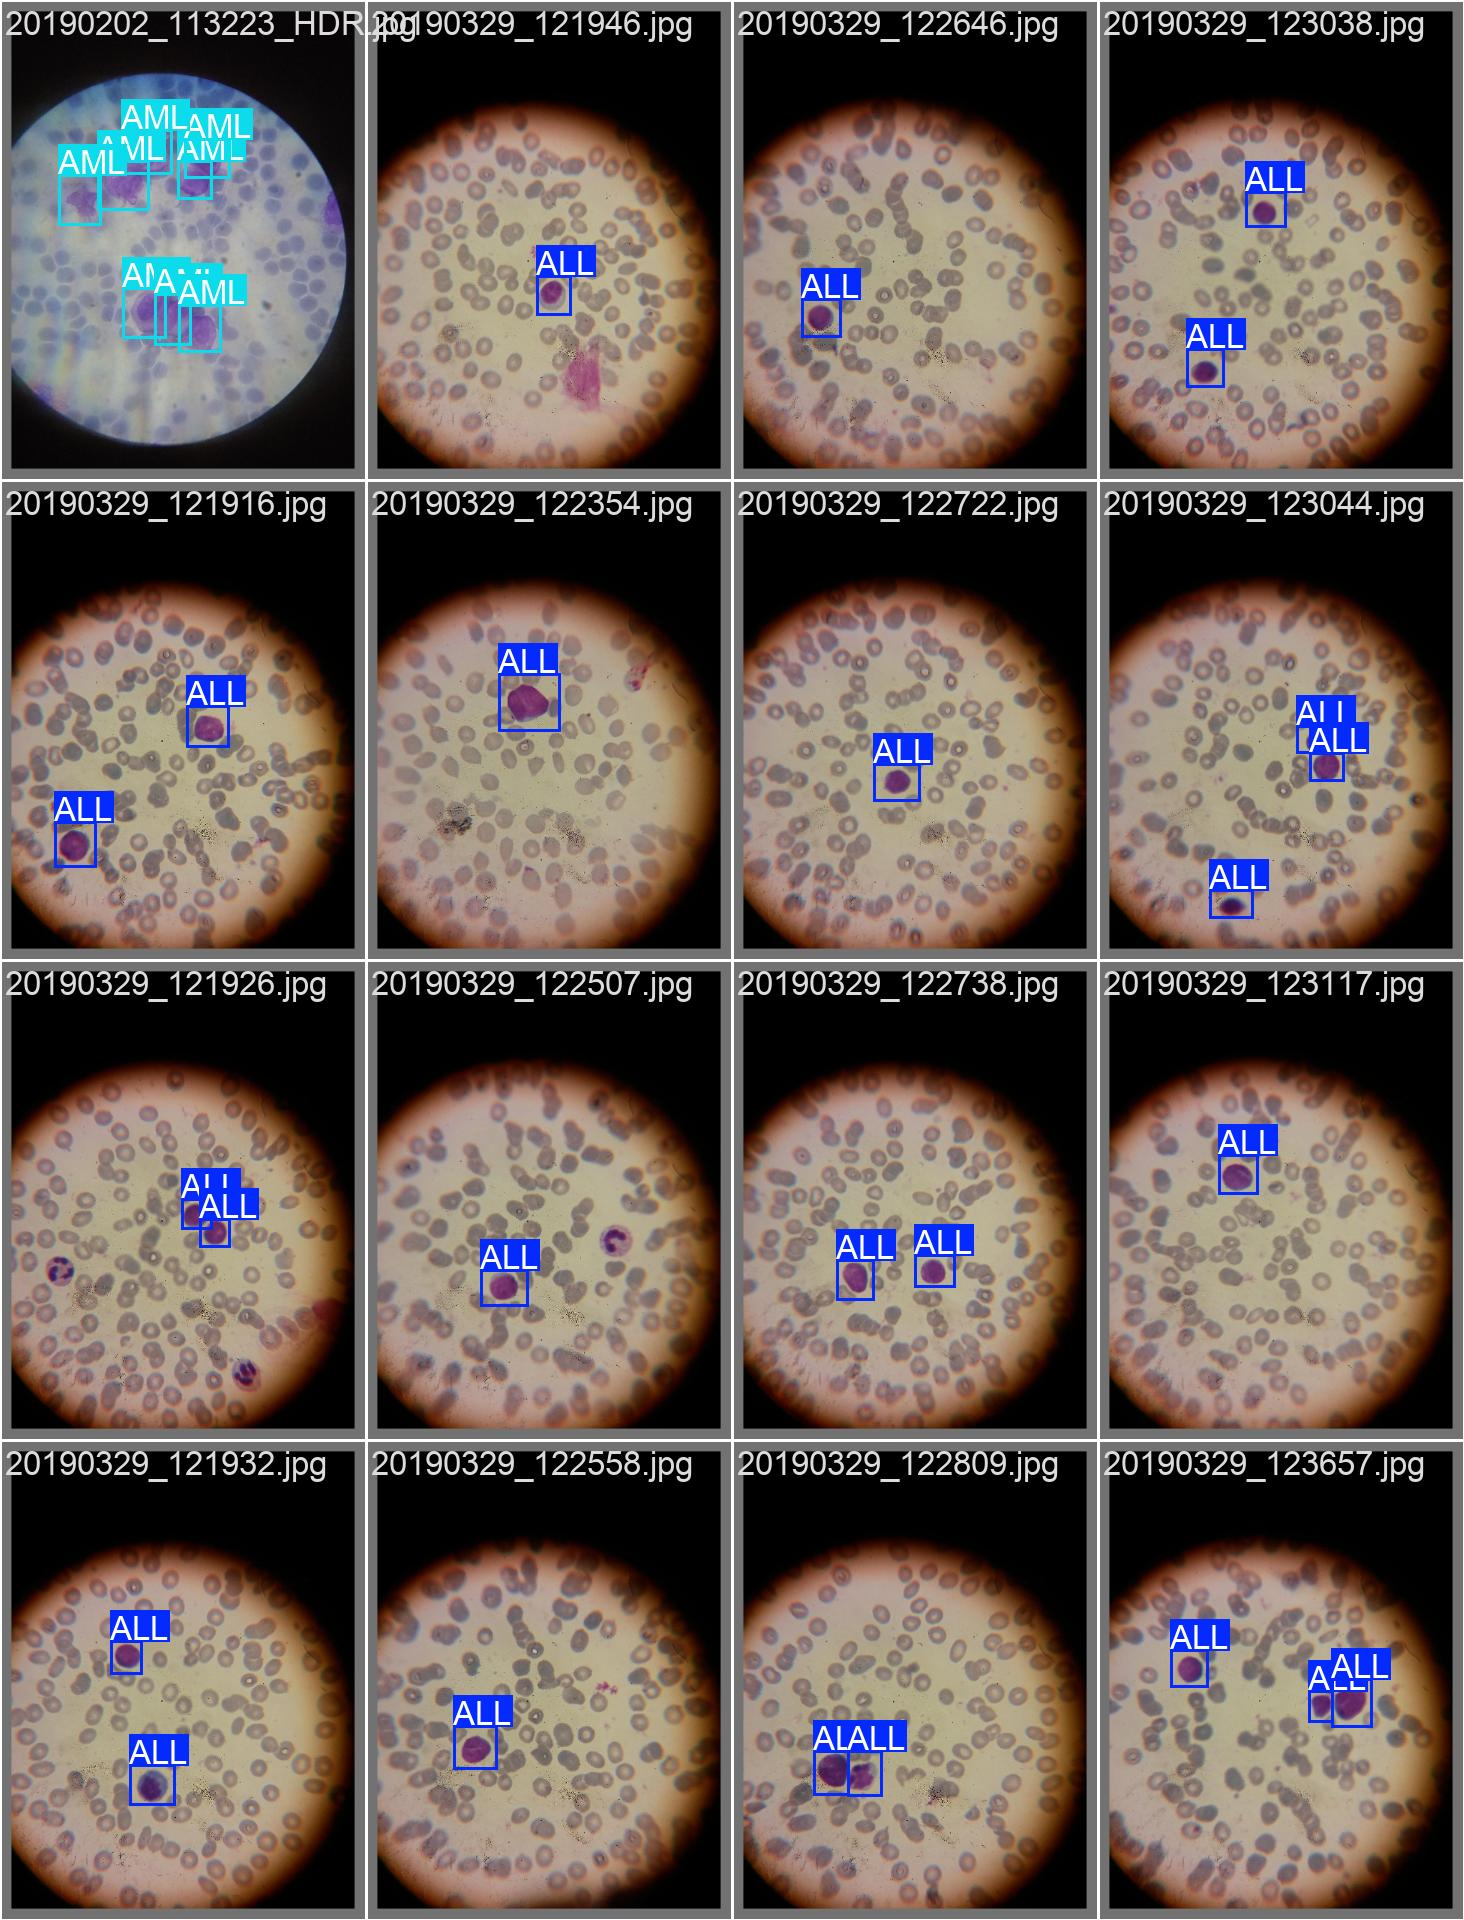

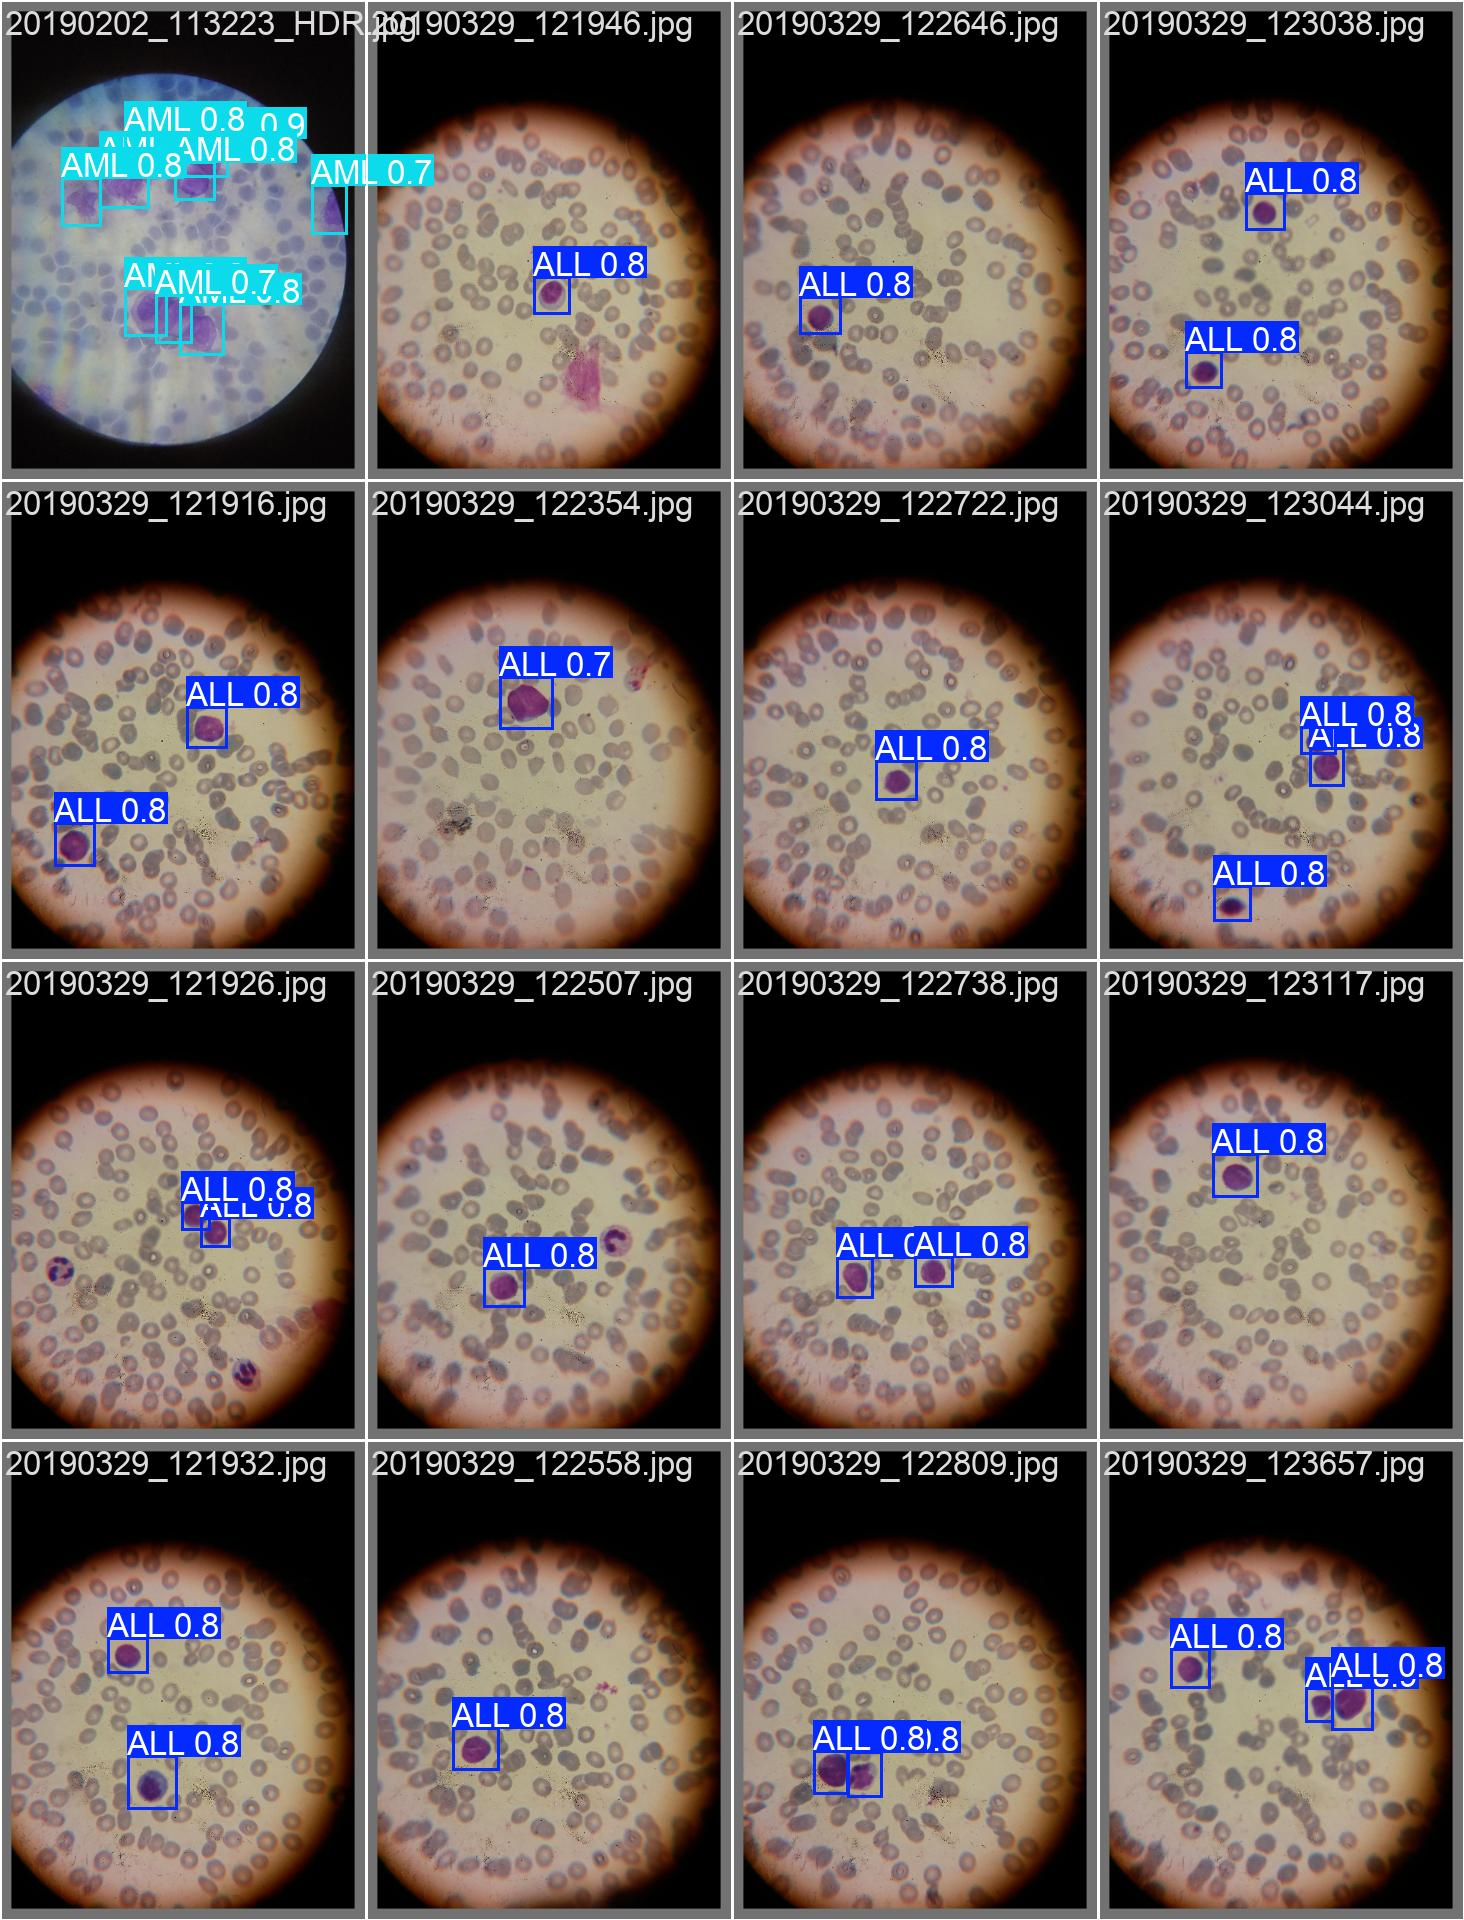

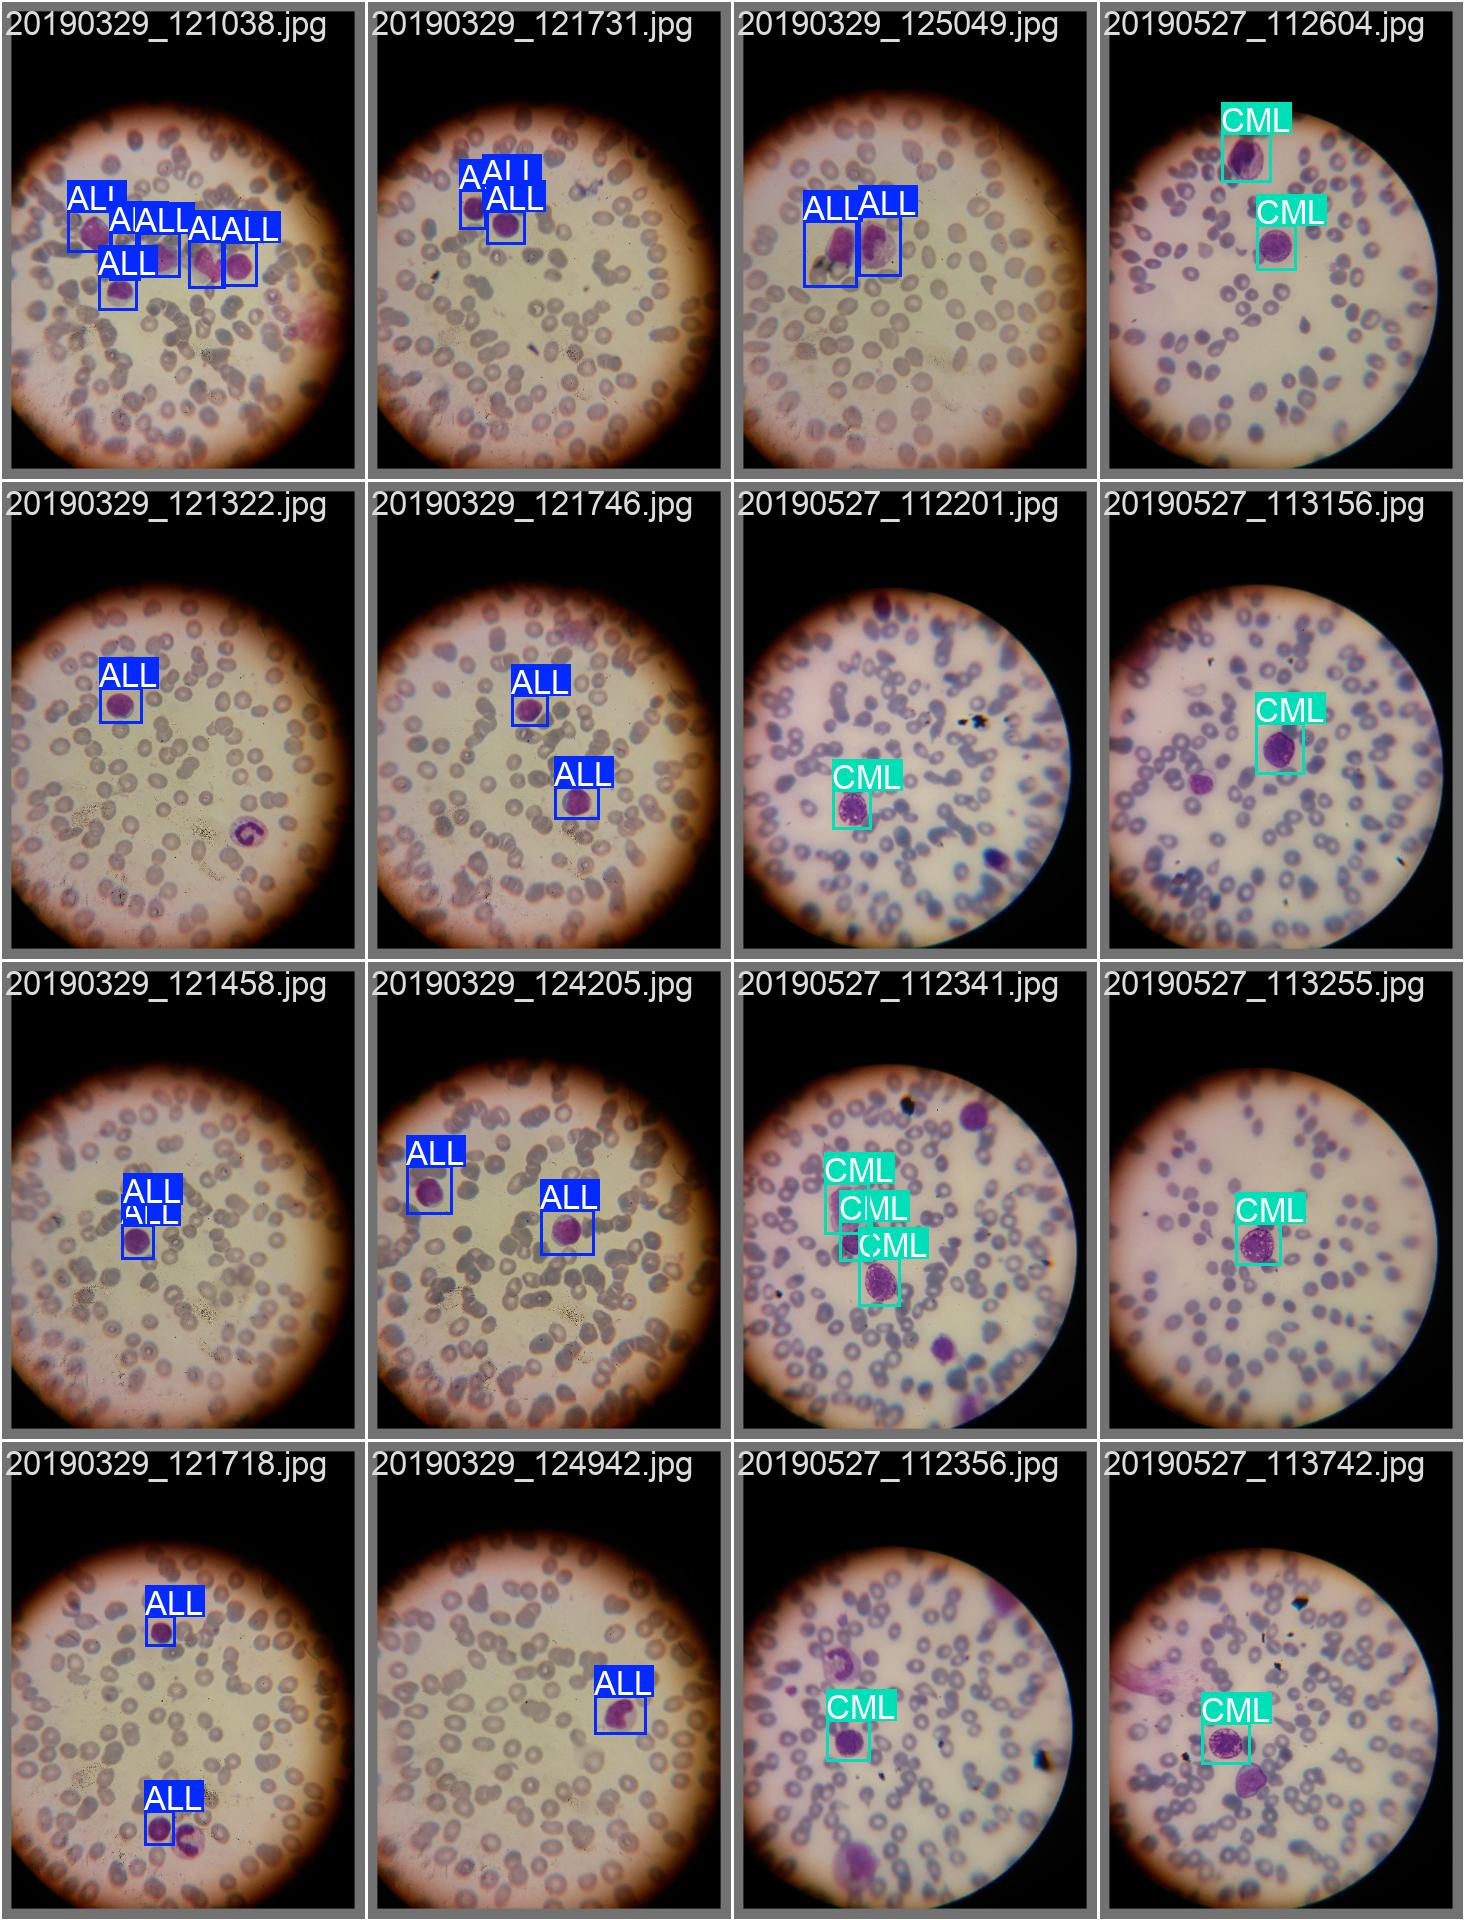

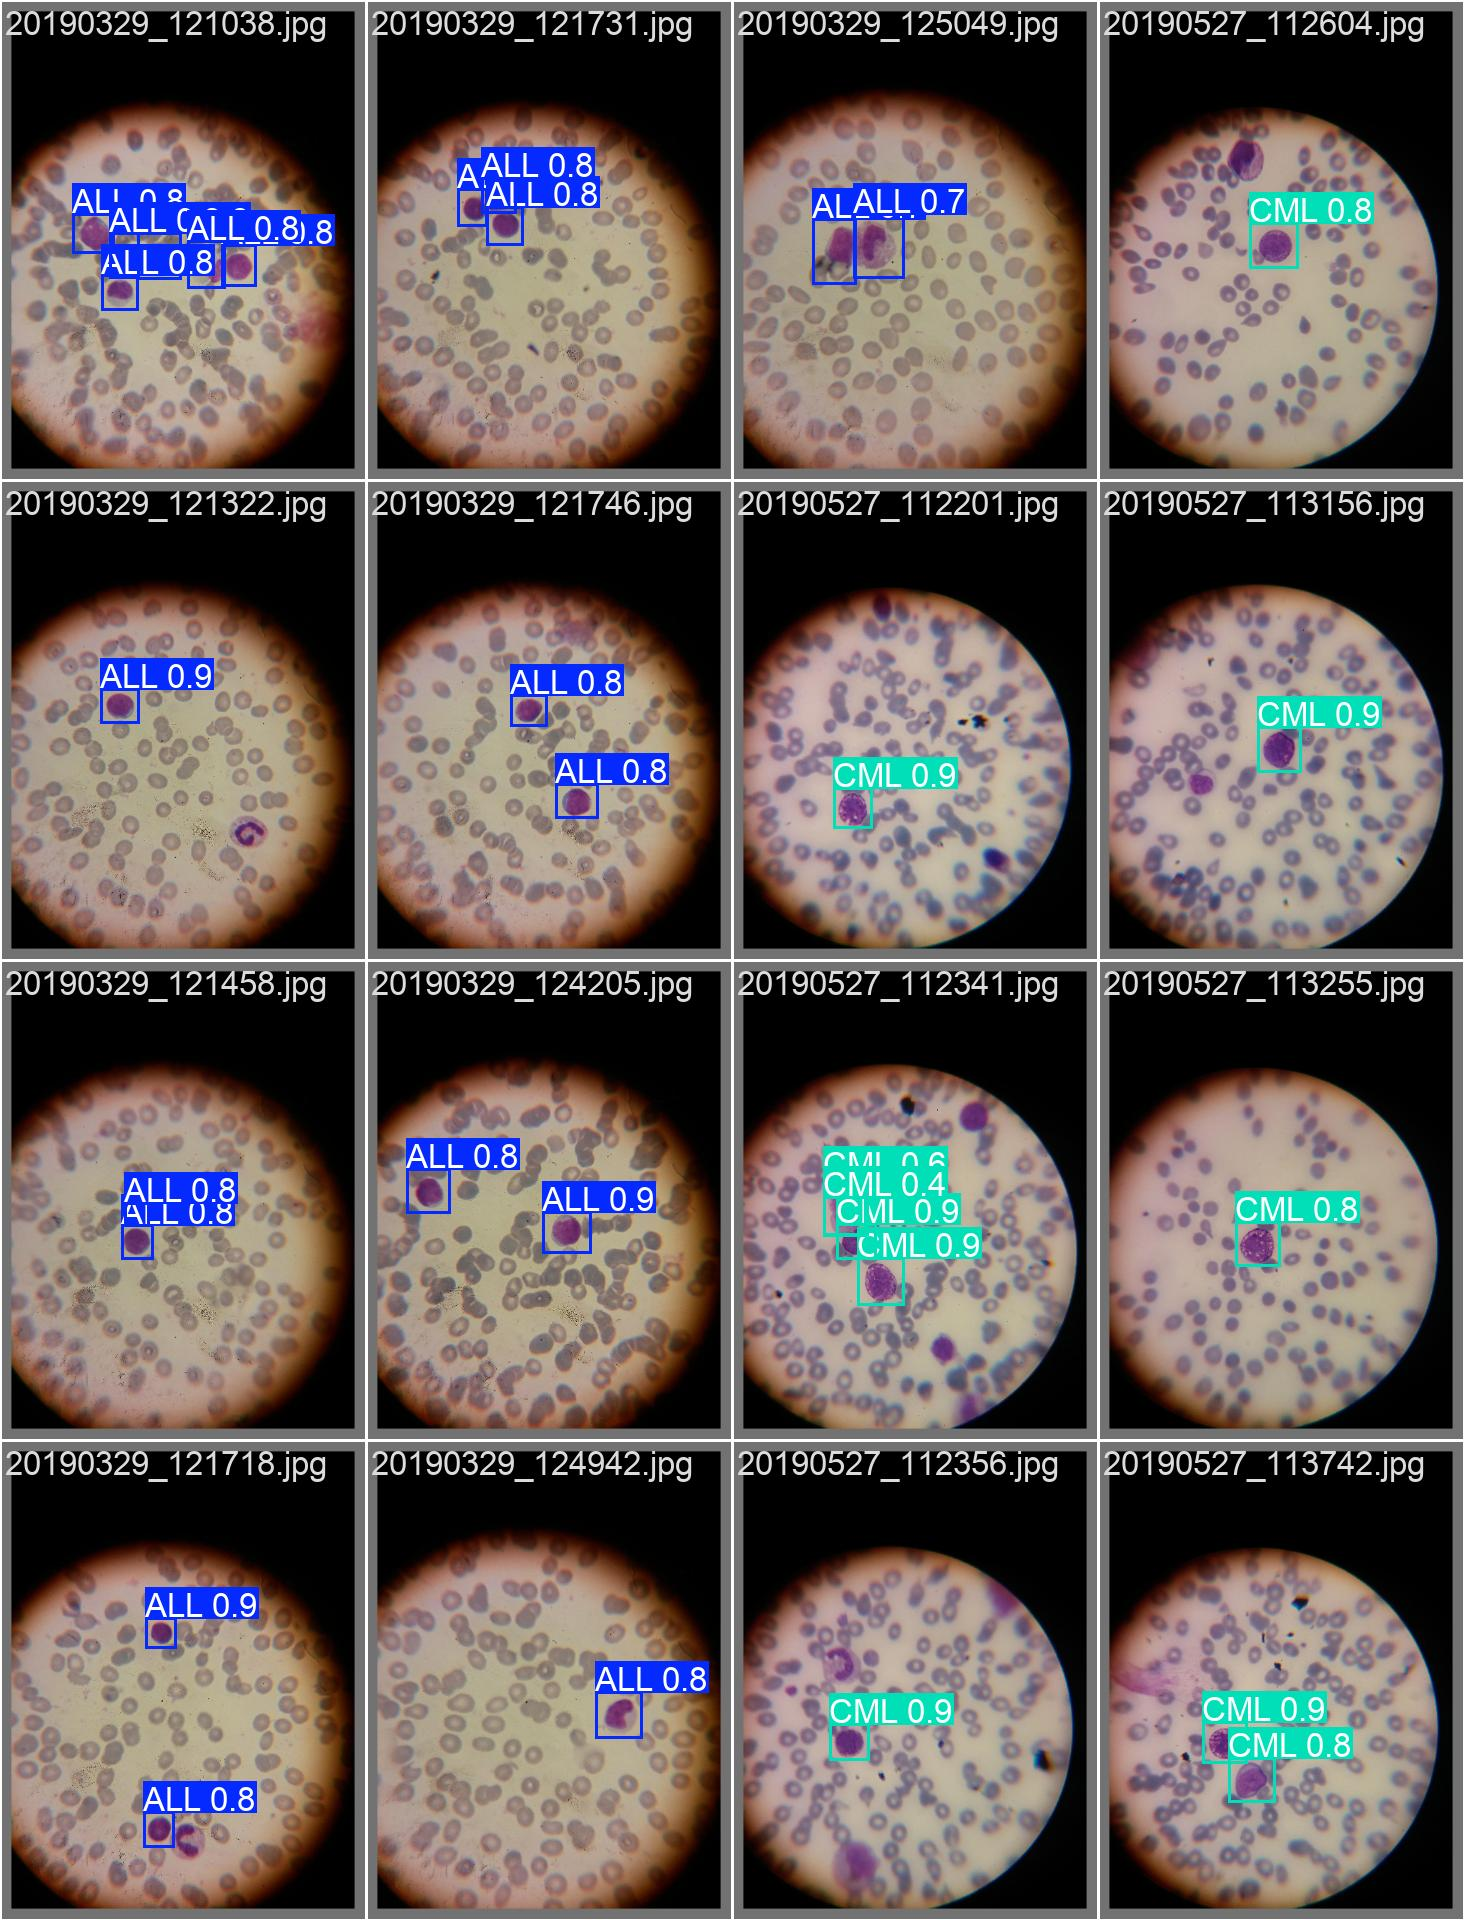

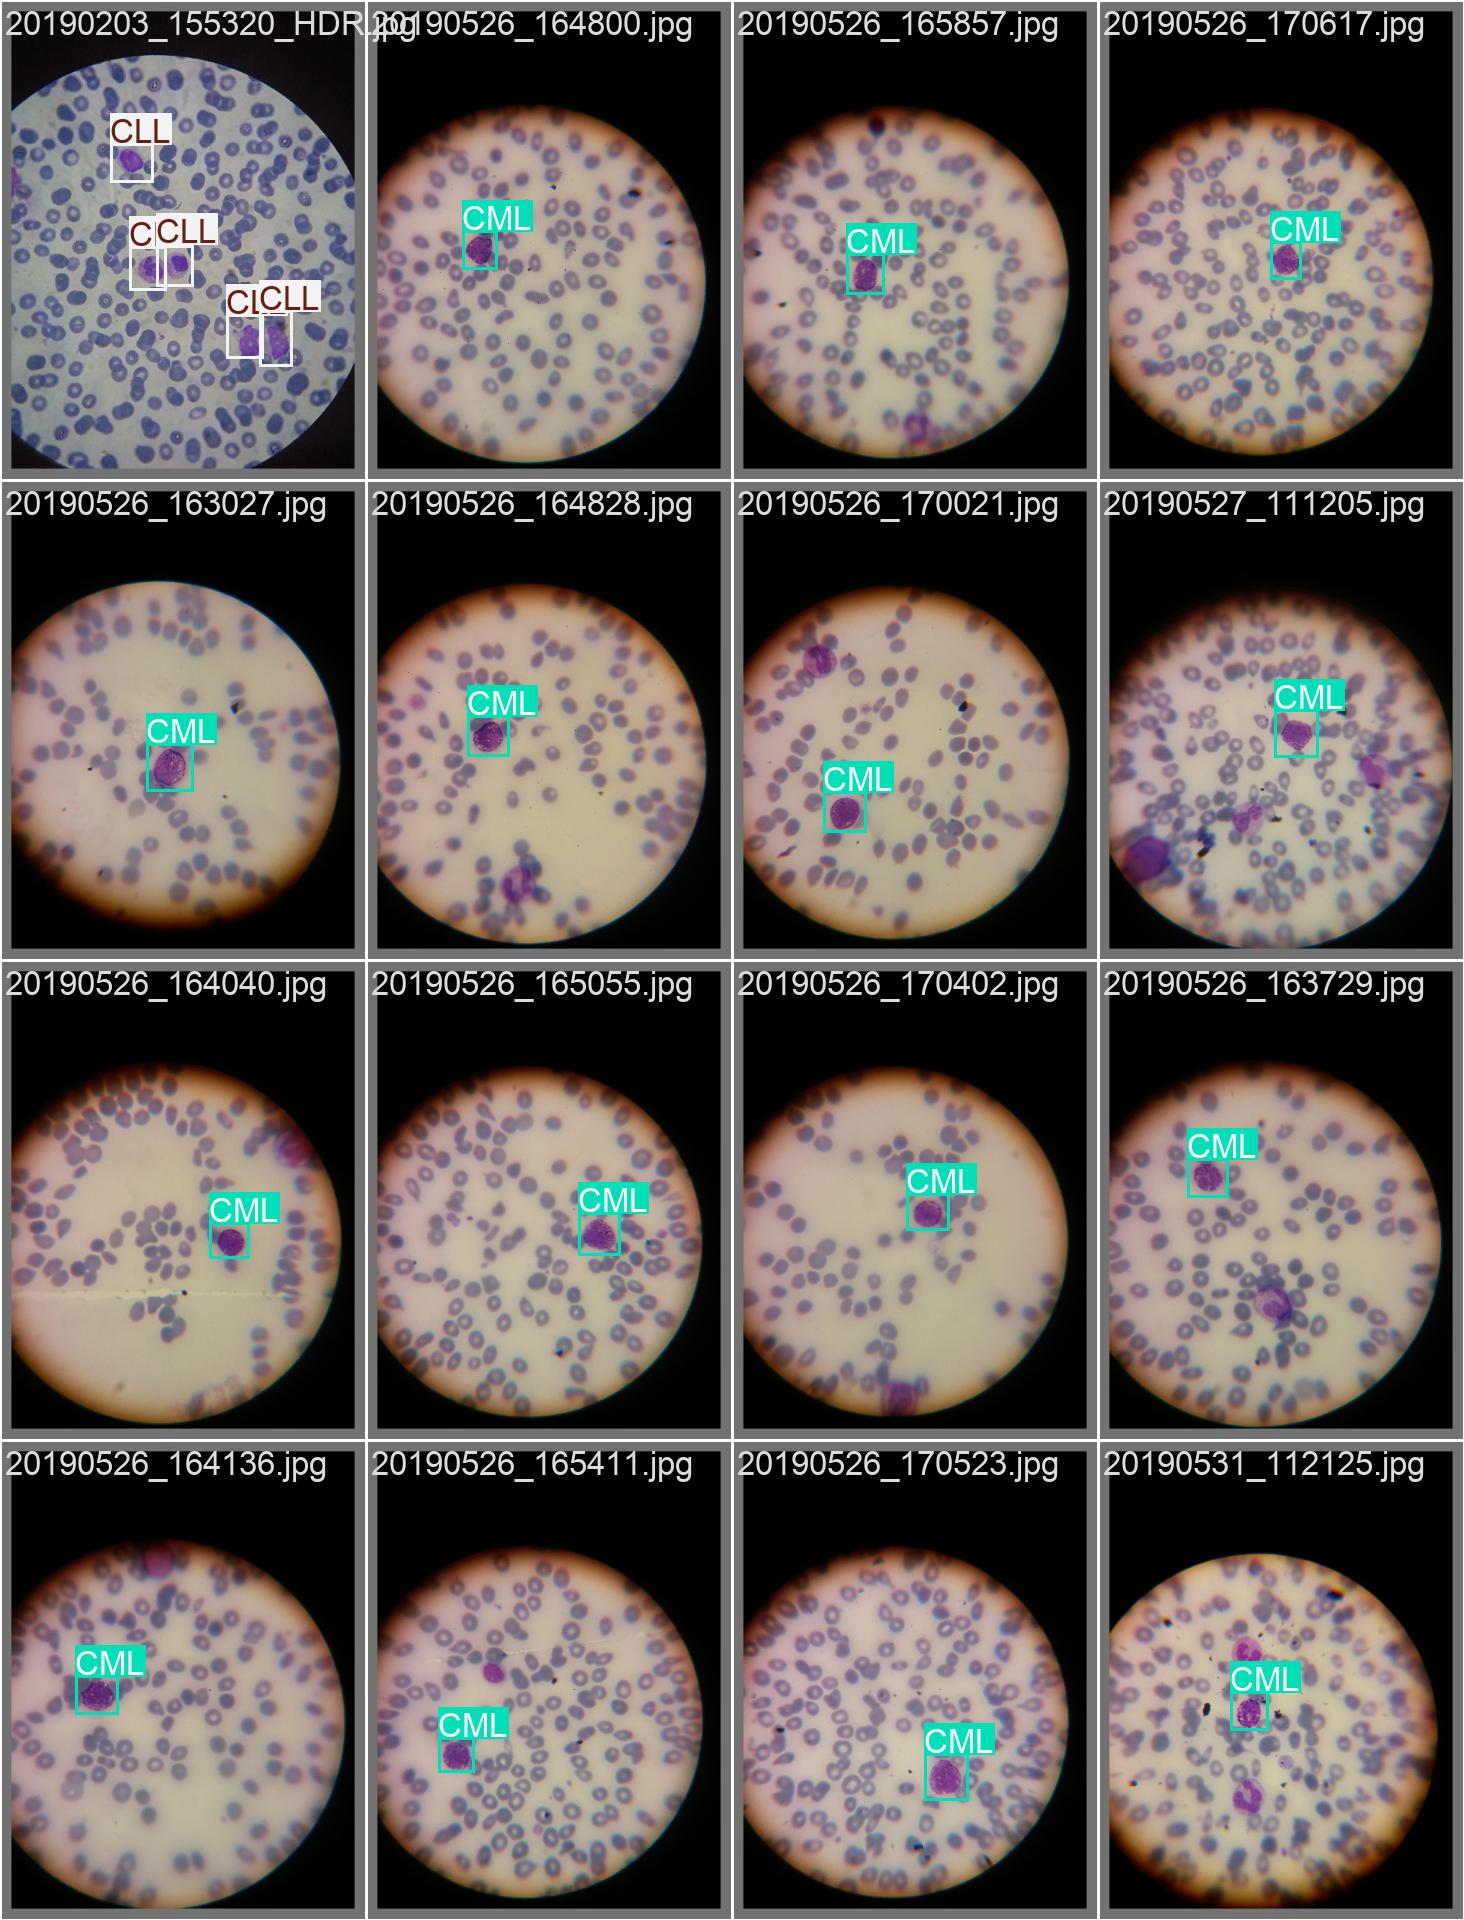

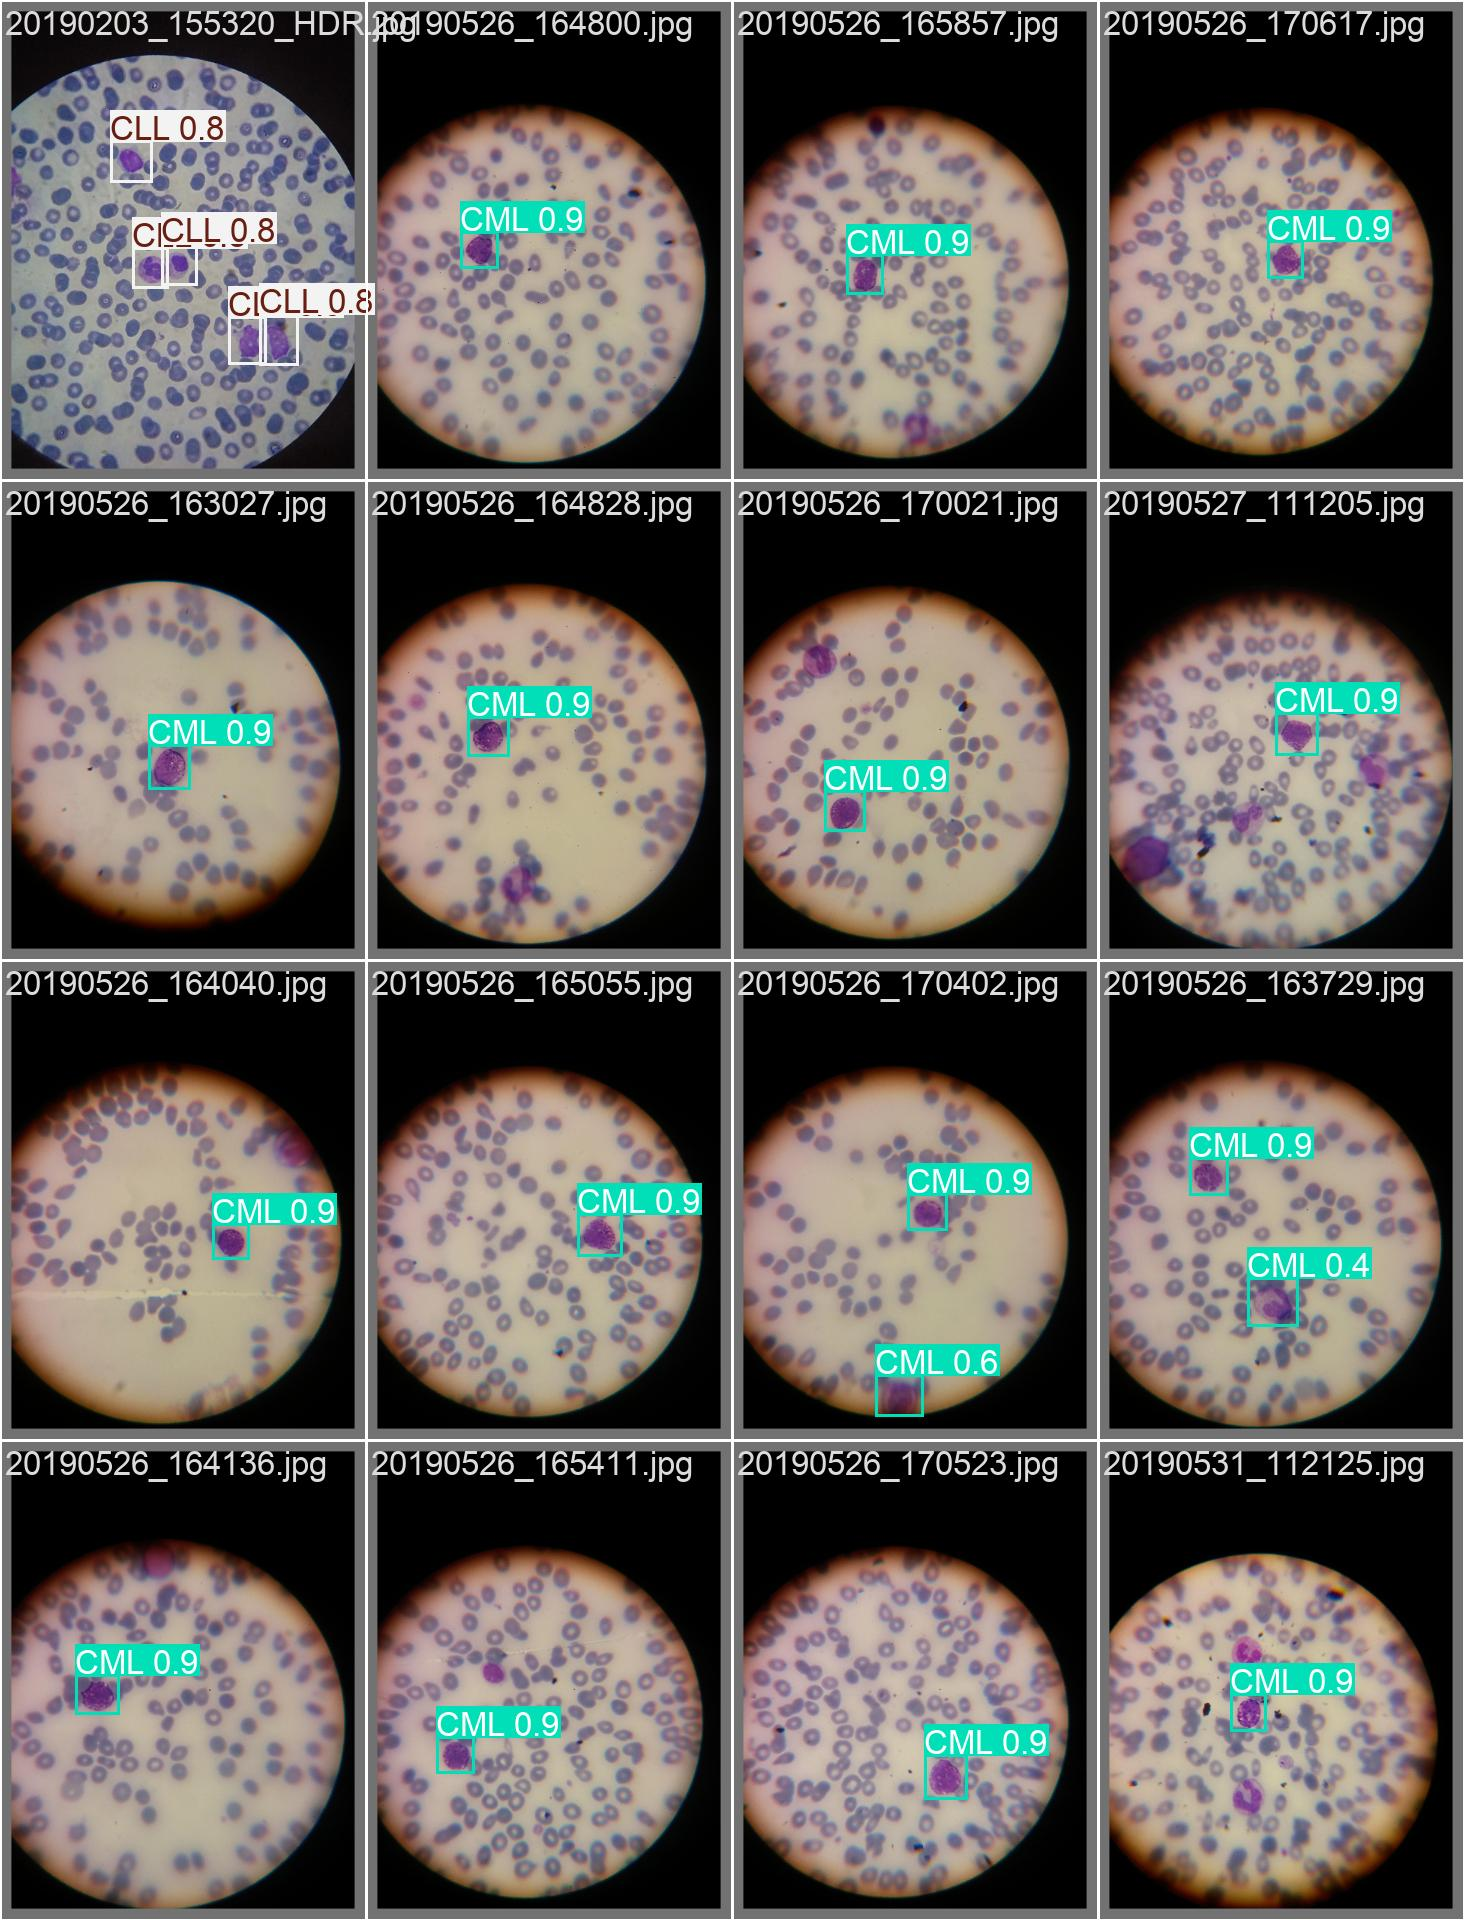

In [48]:
display(Image(filename="runs/detect/leukemia_yolo7/val_batch0_labels.jpg"))
display(Image(filename="runs/detect/leukemia_yolo7/val_batch0_pred.jpg"))

display(Image(filename="runs/detect/leukemia_yolo7/val_batch1_labels.jpg"))
display(Image(filename="runs/detect/leukemia_yolo7/val_batch1_pred.jpg"))

display(Image(filename="runs/detect/leukemia_yolo7/val_batch2_labels.jpg"))
display(Image(filename="runs/detect/leukemia_yolo7/val_batch2_pred.jpg"))